# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
checkpoints_dir = './checkpoints'
data_dir = './data'
figures_dir = './figures'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [2]:
!mkdir ./checkpoints
!mkdir ./figures

mkdir: cannot create directory ‘./checkpoints’: File exists
mkdir: cannot create directory ‘./figures’: File exists


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

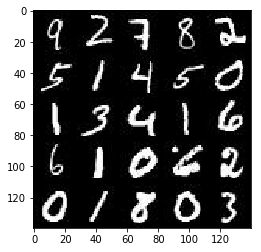

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import matplotlib.pyplot as plt

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

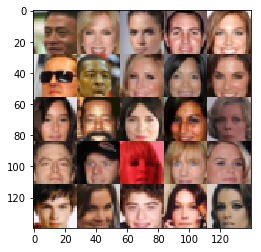

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/home/adrian/miniconda3/envs/udacity_dlfnd/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_dim = (image_height, image_width, image_channels)
    
    inputs_real = tf.placeholder(tf.float32, shape=(None, *real_dim), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # layer 1
        #   -> in: 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(alpha * x, x)
        # print('x1: {}'.format(x)) # shape=(?, 14, 14, 64)
        
        # layer 2
        #   -> in: 14x14x64
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # print('x2: {}'.format(x)) # shape=(?, 7, 7, 128)
        
        # layer 3
        #   -> in: 7x7x128
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # print('x3: {}'.format(x)) # shape=(?, 4, 4, 256)
        
        # flatten
        #   -> in: 4x4x256
        x = tf.reshape(x, (-1, 4*4*256))
        # print('flatten: {}'.format(x)) # shape=(?, 4096)
        
        # outputs
        logits = tf.layers.dense(x, 1)
        # print('logits: {}'.format(logits)) # shape=(?, 1)
        
        out = tf.sigmoid(logits)
        # print('out: {}'.format(out)) # shape=(?, 1)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    
    References:
        -> https://discussions.udacity.com/t/how-tf-layers-conv2d-and-tf-layers-conv2d-transpose-work/249624/2
        -> https://classroom.udacity.com/nanodegrees/nd101/parts/f6d74d04-6d65-424a-9f3a-d58f4da7d406/modules/ca299d5f-35f6-4520-a2b0-74c6878008b3/lessons/2fd24529-215c-47b5-a644-2c23650493f6/concepts/4f028128-6c6a-41e1-80cd-58f54189615d
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        # print('x1: {}'.format(x)) # shape=(?, 8192)
        
        # Reshape it to start the convolutional stack
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 4x4x512 now
        # print('x1: {}'.format(x)) # shape=(?, 4, 4, 512)
        
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7x7x256 now
        # print('x2: {}'.format(x)) # shape=(?, 7, 7, 256)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 14x14x128 now
        # print('x3: {}'.format(x)) # shape=(?, 14, 14, 128)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        # print('logits: {}'.format(logits)) # shape=(?, 28, 28, 5)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import os.path

from datetime import datetime

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    fig = pyplot.imshow(images_grid, cmap=cmap)
    file_name = '_'.join(
        [datetime.now().strftime('%Y%m%d_%H%M%S'), 'samples.png'])
    file_path = os.path.join(figures_dir, file_name)
    plt.savefig(file_path)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count,
          batch_size,
          z_dim,
          learning_rate,
          beta1,
          get_batches,
          data_shape,
          data_image_mode,
          print_every=10,
          show_every=100,
          n_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # set ivars
    losses = []
    steps_i = 0
    out_channel_dim = 1 if data_image_mode == 'L' else 3

    # build model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2],
                                           data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    # train
    print('Training...')
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        images_i = 0
        for epoch_i in range(epoch_count):
            
            batches_i = 0
            for batch_images in get_batches(batch_size):
                steps_i += 1
                batches_i += 1
                images_i += len(batch_images)
                
                # adjust batch images to be in the range (-1, 1)
                batch_images *= 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(
                    d_opt,
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        lr: learning_rate})
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        lr: learning_rate})

                if batches_i % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch: {}/{} ".format(epoch_i + 1, epoch_count),
                          "Batches: {:>4,} ".format(batches_i),
                          "Images seen: {:>6,}".format(images_i),
                          "Discriminator Loss: {:.4f} ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if batches_i % show_every == 0:
                    show_generator_output(sess, n_images, input_z,
                                          out_channel_dim, data_image_mode)
            
            # show final sample
            show_generator_output(sess, n_images, input_z,
                                          out_channel_dim, data_image_mode)
        
        saver.save(sess, checkpoints_dir + '/generator.ckpt')
        

    plt.plot(losses)
    plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Training...
Epoch: 1/2  Batches:   10  Images seen:    640 Discriminator Loss: 0.8119  Generator Loss: 0.7883
Epoch: 1/2  Batches:   20  Images seen:  1,280 Discriminator Loss: 0.4458  Generator Loss: 1.4351
Epoch: 1/2  Batches:   30  Images seen:  1,920 Discriminator Loss: 0.4881  Generator Loss: 1.5392
Epoch: 1/2  Batches:   40  Images seen:  2,560 Discriminator Loss: 0.6065  Generator Loss: 1.0080
Epoch: 1/2  Batches:   50  Images seen:  3,200 Discriminator Loss: 0.4198  Generator Loss: 1.7565
Epoch: 1/2  Batches:   60  Images seen:  3,840 Discriminator Loss: 0.3194  Generator Loss: 2.0539
Epoch: 1/2  Batches:   70  Images seen:  4,480 Discriminator Loss: 0.7203  Generator Loss: 1.0335
Epoch: 1/2  Batches:   80  Images seen:  5,120 Discriminator Loss: 0.7392  Generator Loss: 1.2544
Epoch: 1/2  Batches:   90  Images seen:  5,760 Discriminator Loss: 0.4404  Generator Loss: 1.5904
Epoch: 1/2  Batches:  100  Images seen:  6,400 Discriminator Loss: 0.4054  Generator Loss: 1.9858


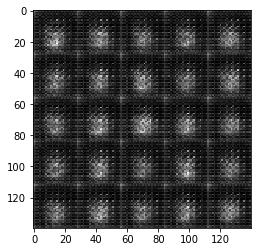

Epoch: 1/2  Batches:  110  Images seen:  7,040 Discriminator Loss: 0.4963  Generator Loss: 2.0907
Epoch: 1/2  Batches:  120  Images seen:  7,680 Discriminator Loss: 0.1657  Generator Loss: 2.5326
Epoch: 1/2  Batches:  130  Images seen:  8,320 Discriminator Loss: 0.4069  Generator Loss: 2.2306
Epoch: 1/2  Batches:  140  Images seen:  8,960 Discriminator Loss: 0.2659  Generator Loss: 2.3144
Epoch: 1/2  Batches:  150  Images seen:  9,600 Discriminator Loss: 0.2351  Generator Loss: 2.2325
Epoch: 1/2  Batches:  160  Images seen: 10,240 Discriminator Loss: 0.2847  Generator Loss: 2.3987
Epoch: 1/2  Batches:  170  Images seen: 10,880 Discriminator Loss: 0.3761  Generator Loss: 2.0232
Epoch: 1/2  Batches:  180  Images seen: 11,520 Discriminator Loss: 0.6293  Generator Loss: 1.7047
Epoch: 1/2  Batches:  190  Images seen: 12,160 Discriminator Loss: 0.6921  Generator Loss: 1.3061
Epoch: 1/2  Batches:  200  Images seen: 12,800 Discriminator Loss: 0.5357  Generator Loss: 1.6773


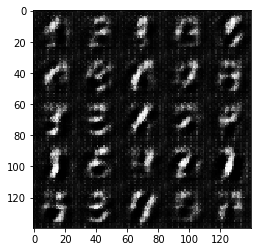

Epoch: 1/2  Batches:  210  Images seen: 13,440 Discriminator Loss: 0.5022  Generator Loss: 1.8638
Epoch: 1/2  Batches:  220  Images seen: 14,080 Discriminator Loss: 0.5330  Generator Loss: 1.4737
Epoch: 1/2  Batches:  230  Images seen: 14,720 Discriminator Loss: 0.7334  Generator Loss: 2.2126
Epoch: 1/2  Batches:  240  Images seen: 15,360 Discriminator Loss: 0.7153  Generator Loss: 1.1353
Epoch: 1/2  Batches:  250  Images seen: 16,000 Discriminator Loss: 0.6543  Generator Loss: 1.6949
Epoch: 1/2  Batches:  260  Images seen: 16,640 Discriminator Loss: 0.7829  Generator Loss: 1.1399
Epoch: 1/2  Batches:  270  Images seen: 17,280 Discriminator Loss: 0.8128  Generator Loss: 1.9199
Epoch: 1/2  Batches:  280  Images seen: 17,920 Discriminator Loss: 0.5771  Generator Loss: 1.5213
Epoch: 1/2  Batches:  290  Images seen: 18,560 Discriminator Loss: 1.9179  Generator Loss: 2.5951
Epoch: 1/2  Batches:  300  Images seen: 19,200 Discriminator Loss: 0.6792  Generator Loss: 2.0617


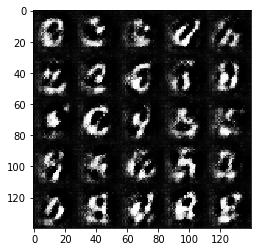

Epoch: 1/2  Batches:  310  Images seen: 19,840 Discriminator Loss: 1.0047  Generator Loss: 0.6913
Epoch: 1/2  Batches:  320  Images seen: 20,480 Discriminator Loss: 0.7098  Generator Loss: 1.0902
Epoch: 1/2  Batches:  330  Images seen: 21,120 Discriminator Loss: 0.7459  Generator Loss: 1.0114
Epoch: 1/2  Batches:  340  Images seen: 21,760 Discriminator Loss: 0.8607  Generator Loss: 1.2992
Epoch: 1/2  Batches:  350  Images seen: 22,400 Discriminator Loss: 0.7510  Generator Loss: 1.3558
Epoch: 1/2  Batches:  360  Images seen: 23,040 Discriminator Loss: 0.6859  Generator Loss: 1.6461
Epoch: 1/2  Batches:  370  Images seen: 23,680 Discriminator Loss: 0.6519  Generator Loss: 1.1530
Epoch: 1/2  Batches:  380  Images seen: 24,320 Discriminator Loss: 0.7852  Generator Loss: 1.0092
Epoch: 1/2  Batches:  390  Images seen: 24,960 Discriminator Loss: 0.6164  Generator Loss: 1.3008
Epoch: 1/2  Batches:  400  Images seen: 25,600 Discriminator Loss: 0.8559  Generator Loss: 0.8139


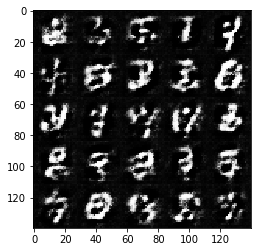

Epoch: 1/2  Batches:  410  Images seen: 26,240 Discriminator Loss: 0.6240  Generator Loss: 1.5414
Epoch: 1/2  Batches:  420  Images seen: 26,880 Discriminator Loss: 0.6144  Generator Loss: 1.2202
Epoch: 1/2  Batches:  430  Images seen: 27,520 Discriminator Loss: 0.8418  Generator Loss: 0.7747
Epoch: 1/2  Batches:  440  Images seen: 28,160 Discriminator Loss: 0.6273  Generator Loss: 1.4936
Epoch: 1/2  Batches:  450  Images seen: 28,800 Discriminator Loss: 0.6673  Generator Loss: 1.1162
Epoch: 1/2  Batches:  460  Images seen: 29,440 Discriminator Loss: 0.5402  Generator Loss: 1.7197
Epoch: 1/2  Batches:  470  Images seen: 30,080 Discriminator Loss: 0.9180  Generator Loss: 0.6741
Epoch: 1/2  Batches:  480  Images seen: 30,720 Discriminator Loss: 0.6177  Generator Loss: 1.2168
Epoch: 1/2  Batches:  490  Images seen: 31,360 Discriminator Loss: 0.6867  Generator Loss: 2.6518
Epoch: 1/2  Batches:  500  Images seen: 32,000 Discriminator Loss: 0.5784  Generator Loss: 1.7899


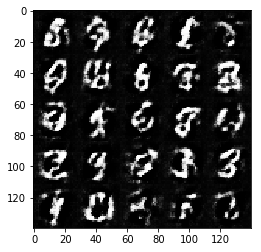

Epoch: 1/2  Batches:  510  Images seen: 32,640 Discriminator Loss: 0.5517  Generator Loss: 1.2810
Epoch: 1/2  Batches:  520  Images seen: 33,280 Discriminator Loss: 0.6158  Generator Loss: 1.1959
Epoch: 1/2  Batches:  530  Images seen: 33,920 Discriminator Loss: 0.6588  Generator Loss: 1.9319
Epoch: 1/2  Batches:  540  Images seen: 34,560 Discriminator Loss: 0.7988  Generator Loss: 0.8260
Epoch: 1/2  Batches:  550  Images seen: 35,200 Discriminator Loss: 0.4731  Generator Loss: 1.7315
Epoch: 1/2  Batches:  560  Images seen: 35,840 Discriminator Loss: 0.6129  Generator Loss: 1.1667
Epoch: 1/2  Batches:  570  Images seen: 36,480 Discriminator Loss: 0.5535  Generator Loss: 1.5486
Epoch: 1/2  Batches:  580  Images seen: 37,120 Discriminator Loss: 0.5149  Generator Loss: 1.5636
Epoch: 1/2  Batches:  590  Images seen: 37,760 Discriminator Loss: 0.5387  Generator Loss: 2.4101
Epoch: 1/2  Batches:  600  Images seen: 38,400 Discriminator Loss: 0.5438  Generator Loss: 1.8740


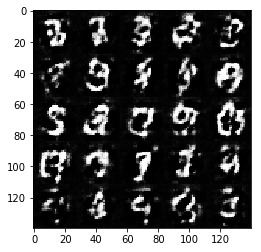

Epoch: 1/2  Batches:  610  Images seen: 39,040 Discriminator Loss: 0.5362  Generator Loss: 1.3015
Epoch: 1/2  Batches:  620  Images seen: 39,680 Discriminator Loss: 0.6614  Generator Loss: 2.4005
Epoch: 1/2  Batches:  630  Images seen: 40,320 Discriminator Loss: 0.6004  Generator Loss: 2.0382
Epoch: 1/2  Batches:  640  Images seen: 40,960 Discriminator Loss: 0.5704  Generator Loss: 1.3326
Epoch: 1/2  Batches:  650  Images seen: 41,600 Discriminator Loss: 0.6948  Generator Loss: 0.9154
Epoch: 1/2  Batches:  660  Images seen: 42,240 Discriminator Loss: 0.5844  Generator Loss: 1.2001
Epoch: 1/2  Batches:  670  Images seen: 42,880 Discriminator Loss: 0.4776  Generator Loss: 2.0006
Epoch: 1/2  Batches:  680  Images seen: 43,520 Discriminator Loss: 0.7551  Generator Loss: 2.6157
Epoch: 1/2  Batches:  690  Images seen: 44,160 Discriminator Loss: 0.7469  Generator Loss: 2.2045
Epoch: 1/2  Batches:  700  Images seen: 44,800 Discriminator Loss: 0.6678  Generator Loss: 2.4342


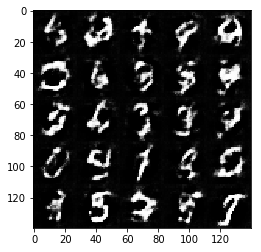

Epoch: 1/2  Batches:  710  Images seen: 45,440 Discriminator Loss: 0.5456  Generator Loss: 2.4307
Epoch: 1/2  Batches:  720  Images seen: 46,080 Discriminator Loss: 0.5605  Generator Loss: 1.4913
Epoch: 1/2  Batches:  730  Images seen: 46,720 Discriminator Loss: 0.4588  Generator Loss: 1.6611
Epoch: 1/2  Batches:  740  Images seen: 47,360 Discriminator Loss: 0.6969  Generator Loss: 1.1972
Epoch: 1/2  Batches:  750  Images seen: 48,000 Discriminator Loss: 0.5578  Generator Loss: 1.2872
Epoch: 1/2  Batches:  760  Images seen: 48,640 Discriminator Loss: 0.5173  Generator Loss: 1.6048
Epoch: 1/2  Batches:  770  Images seen: 49,280 Discriminator Loss: 0.5674  Generator Loss: 1.2223
Epoch: 1/2  Batches:  780  Images seen: 49,920 Discriminator Loss: 0.4831  Generator Loss: 1.9561
Epoch: 1/2  Batches:  790  Images seen: 50,560 Discriminator Loss: 0.6159  Generator Loss: 1.1388
Epoch: 1/2  Batches:  800  Images seen: 51,200 Discriminator Loss: 0.6536  Generator Loss: 2.0531


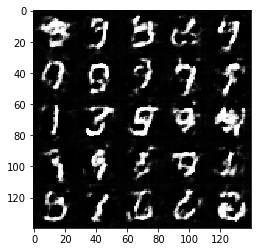

Epoch: 1/2  Batches:  810  Images seen: 51,840 Discriminator Loss: 0.6238  Generator Loss: 1.5588
Epoch: 1/2  Batches:  820  Images seen: 52,480 Discriminator Loss: 0.5581  Generator Loss: 1.7793
Epoch: 1/2  Batches:  830  Images seen: 53,120 Discriminator Loss: 0.8006  Generator Loss: 0.7721
Epoch: 1/2  Batches:  840  Images seen: 53,760 Discriminator Loss: 0.9447  Generator Loss: 0.6591
Epoch: 1/2  Batches:  850  Images seen: 54,400 Discriminator Loss: 0.5670  Generator Loss: 1.6167
Epoch: 1/2  Batches:  860  Images seen: 55,040 Discriminator Loss: 0.6257  Generator Loss: 2.1076
Epoch: 1/2  Batches:  870  Images seen: 55,680 Discriminator Loss: 0.7108  Generator Loss: 2.4307
Epoch: 1/2  Batches:  880  Images seen: 56,320 Discriminator Loss: 0.6273  Generator Loss: 1.1875
Epoch: 1/2  Batches:  890  Images seen: 56,960 Discriminator Loss: 0.5658  Generator Loss: 1.7086
Epoch: 1/2  Batches:  900  Images seen: 57,600 Discriminator Loss: 0.5598  Generator Loss: 1.5598


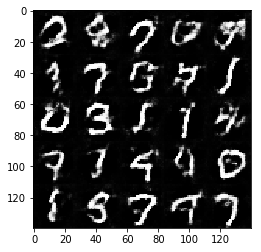

Epoch: 1/2  Batches:  910  Images seen: 58,240 Discriminator Loss: 0.6050  Generator Loss: 1.2435
Epoch: 1/2  Batches:  920  Images seen: 58,880 Discriminator Loss: 0.6026  Generator Loss: 2.2181
Epoch: 1/2  Batches:  930  Images seen: 59,520 Discriminator Loss: 0.7676  Generator Loss: 0.8589


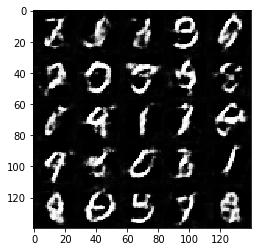

Epoch: 2/2  Batches:   10  Images seen: 60,608 Discriminator Loss: 0.5758  Generator Loss: 1.3368
Epoch: 2/2  Batches:   20  Images seen: 61,248 Discriminator Loss: 0.8836  Generator Loss: 0.7484
Epoch: 2/2  Batches:   30  Images seen: 61,888 Discriminator Loss: 0.6849  Generator Loss: 1.5016
Epoch: 2/2  Batches:   40  Images seen: 62,528 Discriminator Loss: 0.9513  Generator Loss: 2.6051
Epoch: 2/2  Batches:   50  Images seen: 63,168 Discriminator Loss: 0.8306  Generator Loss: 1.6976
Epoch: 2/2  Batches:   60  Images seen: 63,808 Discriminator Loss: 0.6693  Generator Loss: 1.3397
Epoch: 2/2  Batches:   70  Images seen: 64,448 Discriminator Loss: 0.6032  Generator Loss: 1.8664
Epoch: 2/2  Batches:   80  Images seen: 65,088 Discriminator Loss: 0.6110  Generator Loss: 1.6026
Epoch: 2/2  Batches:   90  Images seen: 65,728 Discriminator Loss: 0.6430  Generator Loss: 1.2347
Epoch: 2/2  Batches:  100  Images seen: 66,368 Discriminator Loss: 0.6175  Generator Loss: 1.2601


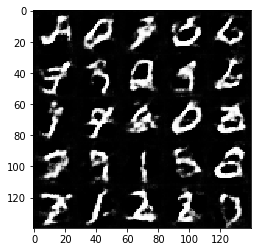

Epoch: 2/2  Batches:  110  Images seen: 67,008 Discriminator Loss: 0.6879  Generator Loss: 1.3037
Epoch: 2/2  Batches:  120  Images seen: 67,648 Discriminator Loss: 0.6268  Generator Loss: 1.6899
Epoch: 2/2  Batches:  130  Images seen: 68,288 Discriminator Loss: 0.7053  Generator Loss: 1.6770
Epoch: 2/2  Batches:  140  Images seen: 68,928 Discriminator Loss: 0.6217  Generator Loss: 1.2767
Epoch: 2/2  Batches:  150  Images seen: 69,568 Discriminator Loss: 0.7350  Generator Loss: 1.0028
Epoch: 2/2  Batches:  160  Images seen: 70,208 Discriminator Loss: 0.5543  Generator Loss: 1.5957
Epoch: 2/2  Batches:  170  Images seen: 70,848 Discriminator Loss: 0.6087  Generator Loss: 1.5228
Epoch: 2/2  Batches:  180  Images seen: 71,488 Discriminator Loss: 0.6645  Generator Loss: 1.3054
Epoch: 2/2  Batches:  190  Images seen: 72,128 Discriminator Loss: 1.1126  Generator Loss: 0.5553
Epoch: 2/2  Batches:  200  Images seen: 72,768 Discriminator Loss: 0.5899  Generator Loss: 1.1936


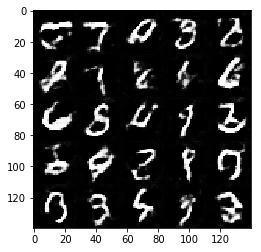

Epoch: 2/2  Batches:  210  Images seen: 73,408 Discriminator Loss: 0.6980  Generator Loss: 0.9798
Epoch: 2/2  Batches:  220  Images seen: 74,048 Discriminator Loss: 0.6345  Generator Loss: 1.6647
Epoch: 2/2  Batches:  230  Images seen: 74,688 Discriminator Loss: 0.7538  Generator Loss: 0.9596
Epoch: 2/2  Batches:  240  Images seen: 75,328 Discriminator Loss: 0.6493  Generator Loss: 2.2712
Epoch: 2/2  Batches:  250  Images seen: 75,968 Discriminator Loss: 0.5159  Generator Loss: 1.7586
Epoch: 2/2  Batches:  260  Images seen: 76,608 Discriminator Loss: 0.6265  Generator Loss: 1.6772
Epoch: 2/2  Batches:  270  Images seen: 77,248 Discriminator Loss: 0.7772  Generator Loss: 0.8981
Epoch: 2/2  Batches:  280  Images seen: 77,888 Discriminator Loss: 0.6483  Generator Loss: 1.8965
Epoch: 2/2  Batches:  290  Images seen: 78,528 Discriminator Loss: 0.7091  Generator Loss: 1.9501
Epoch: 2/2  Batches:  300  Images seen: 79,168 Discriminator Loss: 0.8528  Generator Loss: 0.8011


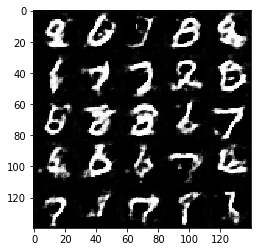

Epoch: 2/2  Batches:  310  Images seen: 79,808 Discriminator Loss: 0.5969  Generator Loss: 1.5736
Epoch: 2/2  Batches:  320  Images seen: 80,448 Discriminator Loss: 0.5758  Generator Loss: 1.8767
Epoch: 2/2  Batches:  330  Images seen: 81,088 Discriminator Loss: 0.5385  Generator Loss: 2.0153
Epoch: 2/2  Batches:  340  Images seen: 81,728 Discriminator Loss: 0.6191  Generator Loss: 1.4970
Epoch: 2/2  Batches:  350  Images seen: 82,368 Discriminator Loss: 0.7929  Generator Loss: 0.8450
Epoch: 2/2  Batches:  360  Images seen: 83,008 Discriminator Loss: 0.5255  Generator Loss: 1.3858
Epoch: 2/2  Batches:  370  Images seen: 83,648 Discriminator Loss: 1.0261  Generator Loss: 0.5957
Epoch: 2/2  Batches:  380  Images seen: 84,288 Discriminator Loss: 0.7364  Generator Loss: 0.9809
Epoch: 2/2  Batches:  390  Images seen: 84,928 Discriminator Loss: 0.6841  Generator Loss: 1.0771
Epoch: 2/2  Batches:  400  Images seen: 85,568 Discriminator Loss: 0.6566  Generator Loss: 1.3440


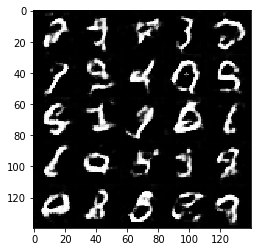

Epoch: 2/2  Batches:  410  Images seen: 86,208 Discriminator Loss: 0.7118  Generator Loss: 0.9720
Epoch: 2/2  Batches:  420  Images seen: 86,848 Discriminator Loss: 0.6163  Generator Loss: 1.1633
Epoch: 2/2  Batches:  430  Images seen: 87,488 Discriminator Loss: 0.7745  Generator Loss: 0.9063
Epoch: 2/2  Batches:  440  Images seen: 88,128 Discriminator Loss: 0.5824  Generator Loss: 1.4967
Epoch: 2/2  Batches:  450  Images seen: 88,768 Discriminator Loss: 0.5919  Generator Loss: 1.3823
Epoch: 2/2  Batches:  460  Images seen: 89,408 Discriminator Loss: 0.5826  Generator Loss: 1.3214
Epoch: 2/2  Batches:  470  Images seen: 90,048 Discriminator Loss: 1.2812  Generator Loss: 0.4609
Epoch: 2/2  Batches:  480  Images seen: 90,688 Discriminator Loss: 0.8549  Generator Loss: 0.7580
Epoch: 2/2  Batches:  490  Images seen: 91,328 Discriminator Loss: 0.8474  Generator Loss: 2.8917
Epoch: 2/2  Batches:  500  Images seen: 91,968 Discriminator Loss: 0.5665  Generator Loss: 1.4292


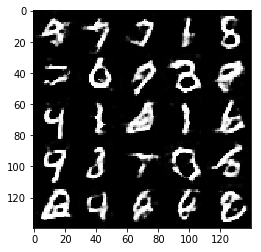

Epoch: 2/2  Batches:  510  Images seen: 92,608 Discriminator Loss: 0.5187  Generator Loss: 1.2945
Epoch: 2/2  Batches:  520  Images seen: 93,248 Discriminator Loss: 0.6379  Generator Loss: 1.1634
Epoch: 2/2  Batches:  530  Images seen: 93,888 Discriminator Loss: 0.4967  Generator Loss: 1.4776
Epoch: 2/2  Batches:  540  Images seen: 94,528 Discriminator Loss: 0.4701  Generator Loss: 1.6468
Epoch: 2/2  Batches:  550  Images seen: 95,168 Discriminator Loss: 0.5349  Generator Loss: 1.2957
Epoch: 2/2  Batches:  560  Images seen: 95,808 Discriminator Loss: 0.5614  Generator Loss: 2.3974
Epoch: 2/2  Batches:  570  Images seen: 96,448 Discriminator Loss: 0.5039  Generator Loss: 1.5124
Epoch: 2/2  Batches:  580  Images seen: 97,088 Discriminator Loss: 0.6719  Generator Loss: 1.0438
Epoch: 2/2  Batches:  590  Images seen: 97,728 Discriminator Loss: 0.9079  Generator Loss: 0.6607
Epoch: 2/2  Batches:  600  Images seen: 98,368 Discriminator Loss: 0.4924  Generator Loss: 1.7466


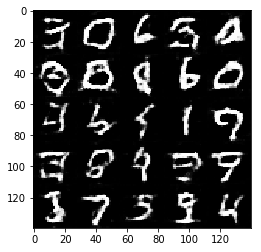

Epoch: 2/2  Batches:  610  Images seen: 99,008 Discriminator Loss: 0.4913  Generator Loss: 1.5476
Epoch: 2/2  Batches:  620  Images seen: 99,648 Discriminator Loss: 1.0710  Generator Loss: 0.5459
Epoch: 2/2  Batches:  630  Images seen: 100,288 Discriminator Loss: 0.6642  Generator Loss: 1.4612
Epoch: 2/2  Batches:  640  Images seen: 100,928 Discriminator Loss: 0.6552  Generator Loss: 1.9054
Epoch: 2/2  Batches:  650  Images seen: 101,568 Discriminator Loss: 0.6969  Generator Loss: 1.0149
Epoch: 2/2  Batches:  660  Images seen: 102,208 Discriminator Loss: 0.4695  Generator Loss: 1.3343
Epoch: 2/2  Batches:  670  Images seen: 102,848 Discriminator Loss: 0.6183  Generator Loss: 1.0630
Epoch: 2/2  Batches:  680  Images seen: 103,488 Discriminator Loss: 0.5847  Generator Loss: 1.1718
Epoch: 2/2  Batches:  690  Images seen: 104,128 Discriminator Loss: 0.8175  Generator Loss: 0.7910
Epoch: 2/2  Batches:  700  Images seen: 104,768 Discriminator Loss: 0.4061  Generator Loss: 1.9792


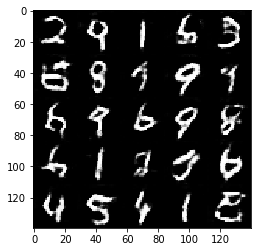

Epoch: 2/2  Batches:  710  Images seen: 105,408 Discriminator Loss: 0.5195  Generator Loss: 1.6670
Epoch: 2/2  Batches:  720  Images seen: 106,048 Discriminator Loss: 0.5586  Generator Loss: 1.7863
Epoch: 2/2  Batches:  730  Images seen: 106,688 Discriminator Loss: 0.4659  Generator Loss: 1.4983
Epoch: 2/2  Batches:  740  Images seen: 107,328 Discriminator Loss: 0.6039  Generator Loss: 1.3904
Epoch: 2/2  Batches:  750  Images seen: 107,968 Discriminator Loss: 0.6082  Generator Loss: 1.1047
Epoch: 2/2  Batches:  760  Images seen: 108,608 Discriminator Loss: 0.5499  Generator Loss: 1.2616
Epoch: 2/2  Batches:  770  Images seen: 109,248 Discriminator Loss: 0.9802  Generator Loss: 0.6562
Epoch: 2/2  Batches:  780  Images seen: 109,888 Discriminator Loss: 0.5970  Generator Loss: 1.2312
Epoch: 2/2  Batches:  790  Images seen: 110,528 Discriminator Loss: 0.6032  Generator Loss: 1.0953
Epoch: 2/2  Batches:  800  Images seen: 111,168 Discriminator Loss: 0.5845  Generator Loss: 1.1057


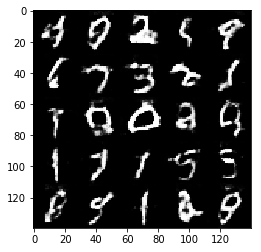

Epoch: 2/2  Batches:  810  Images seen: 111,808 Discriminator Loss: 0.5380  Generator Loss: 1.3603
Epoch: 2/2  Batches:  820  Images seen: 112,448 Discriminator Loss: 0.7549  Generator Loss: 0.7962
Epoch: 2/2  Batches:  830  Images seen: 113,088 Discriminator Loss: 0.6159  Generator Loss: 1.2565
Epoch: 2/2  Batches:  840  Images seen: 113,728 Discriminator Loss: 0.5459  Generator Loss: 1.2103
Epoch: 2/2  Batches:  850  Images seen: 114,368 Discriminator Loss: 2.2684  Generator Loss: 0.1432
Epoch: 2/2  Batches:  860  Images seen: 115,008 Discriminator Loss: 1.3308  Generator Loss: 0.4523
Epoch: 2/2  Batches:  870  Images seen: 115,648 Discriminator Loss: 0.4822  Generator Loss: 1.6045
Epoch: 2/2  Batches:  880  Images seen: 116,288 Discriminator Loss: 0.7696  Generator Loss: 0.8621
Epoch: 2/2  Batches:  890  Images seen: 116,928 Discriminator Loss: 0.6502  Generator Loss: 1.0836
Epoch: 2/2  Batches:  900  Images seen: 117,568 Discriminator Loss: 0.9802  Generator Loss: 0.6207


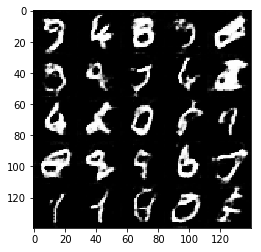

Epoch: 2/2  Batches:  910  Images seen: 118,208 Discriminator Loss: 0.5430  Generator Loss: 1.2336
Epoch: 2/2  Batches:  920  Images seen: 118,848 Discriminator Loss: 0.6102  Generator Loss: 1.4671
Epoch: 2/2  Batches:  930  Images seen: 119,488 Discriminator Loss: 0.4347  Generator Loss: 1.8247


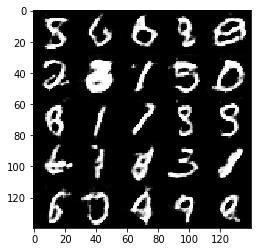

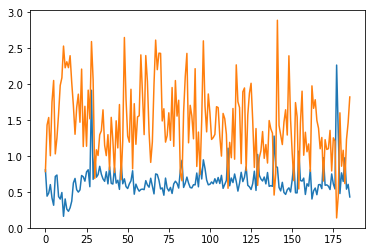

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Training...
Epoch: 1/1  Batches:   10  Images seen:    320 Discriminator Loss: 1.0370  Generator Loss: 0.7327
Epoch: 1/1  Batches:   20  Images seen:    640 Discriminator Loss: 0.6296  Generator Loss: 1.0811
Epoch: 1/1  Batches:   30  Images seen:    960 Discriminator Loss: 0.3594  Generator Loss: 1.6168
Epoch: 1/1  Batches:   40  Images seen:  1,280 Discriminator Loss: 0.3631  Generator Loss: 1.6457
Epoch: 1/1  Batches:   50  Images seen:  1,600 Discriminator Loss: 0.3544  Generator Loss: 1.7200
Epoch: 1/1  Batches:   60  Images seen:  1,920 Discriminator Loss: 0.2206  Generator Loss: 2.3301
Epoch: 1/1  Batches:   70  Images seen:  2,240 Discriminator Loss: 0.2877  Generator Loss: 1.9288
Epoch: 1/1  Batches:   80  Images seen:  2,560 Discriminator Loss: 0.1280  Generator Loss: 4.5153
Epoch: 1/1  Batches:   90  Images seen:  2,880 Discriminator Loss: 0.1784  Generator Loss: 3.2524
Epoch: 1/1  Batches:  100  Images seen:  3,200 Discriminator Loss: 0.2248  Generator Loss: 4.0198


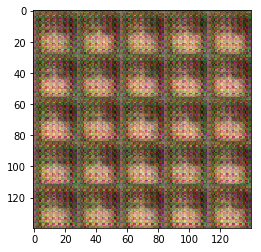

Epoch: 1/1  Batches:  110  Images seen:  3,520 Discriminator Loss: 0.5854  Generator Loss: 1.2260
Epoch: 1/1  Batches:  120  Images seen:  3,840 Discriminator Loss: 0.1729  Generator Loss: 2.4752
Epoch: 1/1  Batches:  130  Images seen:  4,160 Discriminator Loss: 0.1356  Generator Loss: 3.1143
Epoch: 1/1  Batches:  140  Images seen:  4,480 Discriminator Loss: 0.1073  Generator Loss: 3.1070
Epoch: 1/1  Batches:  150  Images seen:  4,800 Discriminator Loss: 0.1603  Generator Loss: 2.5798
Epoch: 1/1  Batches:  160  Images seen:  5,120 Discriminator Loss: 0.1420  Generator Loss: 2.9428
Epoch: 1/1  Batches:  170  Images seen:  5,440 Discriminator Loss: 0.1774  Generator Loss: 4.5428
Epoch: 1/1  Batches:  180  Images seen:  5,760 Discriminator Loss: 0.2057  Generator Loss: 2.1658
Epoch: 1/1  Batches:  190  Images seen:  6,080 Discriminator Loss: 0.3381  Generator Loss: 1.9635
Epoch: 1/1  Batches:  200  Images seen:  6,400 Discriminator Loss: 0.2011  Generator Loss: 2.8196


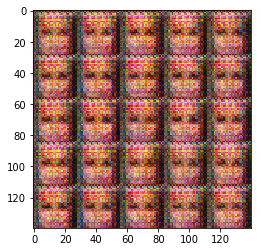

Epoch: 1/1  Batches:  210  Images seen:  6,720 Discriminator Loss: 0.1906  Generator Loss: 2.3732
Epoch: 1/1  Batches:  220  Images seen:  7,040 Discriminator Loss: 0.0813  Generator Loss: 3.2136
Epoch: 1/1  Batches:  230  Images seen:  7,360 Discriminator Loss: 0.0712  Generator Loss: 3.3604
Epoch: 1/1  Batches:  240  Images seen:  7,680 Discriminator Loss: 0.1551  Generator Loss: 2.6197
Epoch: 1/1  Batches:  250  Images seen:  8,000 Discriminator Loss: 0.1755  Generator Loss: 2.3348
Epoch: 1/1  Batches:  260  Images seen:  8,320 Discriminator Loss: 0.1420  Generator Loss: 2.9365
Epoch: 1/1  Batches:  270  Images seen:  8,640 Discriminator Loss: 0.0314  Generator Loss: 3.8487
Epoch: 1/1  Batches:  280  Images seen:  8,960 Discriminator Loss: 0.0906  Generator Loss: 2.7793
Epoch: 1/1  Batches:  290  Images seen:  9,280 Discriminator Loss: 0.0875  Generator Loss: 2.6988
Epoch: 1/1  Batches:  300  Images seen:  9,600 Discriminator Loss: 0.1305  Generator Loss: 3.1581


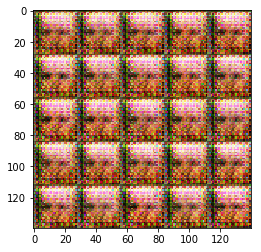

Epoch: 1/1  Batches:  310  Images seen:  9,920 Discriminator Loss: 0.1166  Generator Loss: 2.3229
Epoch: 1/1  Batches:  320  Images seen: 10,240 Discriminator Loss: 0.0350  Generator Loss: 3.7723
Epoch: 1/1  Batches:  330  Images seen: 10,560 Discriminator Loss: 0.0640  Generator Loss: 3.2803
Epoch: 1/1  Batches:  340  Images seen: 10,880 Discriminator Loss: 0.0649  Generator Loss: 3.3344
Epoch: 1/1  Batches:  350  Images seen: 11,200 Discriminator Loss: 0.0598  Generator Loss: 3.5329
Epoch: 1/1  Batches:  360  Images seen: 11,520 Discriminator Loss: 0.0447  Generator Loss: 3.9910
Epoch: 1/1  Batches:  370  Images seen: 11,840 Discriminator Loss: 0.1180  Generator Loss: 3.0425
Epoch: 1/1  Batches:  380  Images seen: 12,160 Discriminator Loss: 0.0317  Generator Loss: 3.6895
Epoch: 1/1  Batches:  390  Images seen: 12,480 Discriminator Loss: 0.0482  Generator Loss: 3.7875
Epoch: 1/1  Batches:  400  Images seen: 12,800 Discriminator Loss: 0.0445  Generator Loss: 3.6645


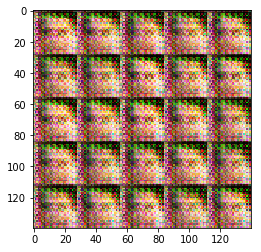

Epoch: 1/1  Batches:  410  Images seen: 13,120 Discriminator Loss: 0.1421  Generator Loss: 2.7441
Epoch: 1/1  Batches:  420  Images seen: 13,440 Discriminator Loss: 0.7428  Generator Loss: 0.7420
Epoch: 1/1  Batches:  430  Images seen: 13,760 Discriminator Loss: 0.7922  Generator Loss: 5.7896
Epoch: 1/1  Batches:  440  Images seen: 14,080 Discriminator Loss: 0.8243  Generator Loss: 0.7107
Epoch: 1/1  Batches:  450  Images seen: 14,400 Discriminator Loss: 0.6225  Generator Loss: 1.0029
Epoch: 1/1  Batches:  460  Images seen: 14,720 Discriminator Loss: 0.6462  Generator Loss: 1.1294
Epoch: 1/1  Batches:  470  Images seen: 15,040 Discriminator Loss: 0.5302  Generator Loss: 2.5292
Epoch: 1/1  Batches:  480  Images seen: 15,360 Discriminator Loss: 0.3554  Generator Loss: 2.7200
Epoch: 1/1  Batches:  490  Images seen: 15,680 Discriminator Loss: 0.1752  Generator Loss: 2.6047
Epoch: 1/1  Batches:  500  Images seen: 16,000 Discriminator Loss: 0.1302  Generator Loss: 3.2762


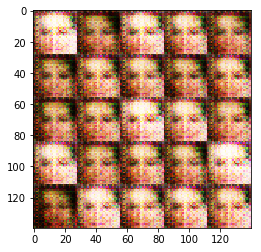

Epoch: 1/1  Batches:  510  Images seen: 16,320 Discriminator Loss: 0.2962  Generator Loss: 2.4941
Epoch: 1/1  Batches:  520  Images seen: 16,640 Discriminator Loss: 0.2283  Generator Loss: 2.4580
Epoch: 1/1  Batches:  530  Images seen: 16,960 Discriminator Loss: 0.4295  Generator Loss: 1.5099
Epoch: 1/1  Batches:  540  Images seen: 17,280 Discriminator Loss: 0.1402  Generator Loss: 4.2618
Epoch: 1/1  Batches:  550  Images seen: 17,600 Discriminator Loss: 0.1464  Generator Loss: 4.5689
Epoch: 1/1  Batches:  560  Images seen: 17,920 Discriminator Loss: 0.2774  Generator Loss: 2.2099
Epoch: 1/1  Batches:  570  Images seen: 18,240 Discriminator Loss: 2.5085  Generator Loss: 0.1108
Epoch: 1/1  Batches:  580  Images seen: 18,560 Discriminator Loss: 0.2910  Generator Loss: 1.6619
Epoch: 1/1  Batches:  590  Images seen: 18,880 Discriminator Loss: 0.5267  Generator Loss: 1.5982
Epoch: 1/1  Batches:  600  Images seen: 19,200 Discriminator Loss: 0.3947  Generator Loss: 1.4774


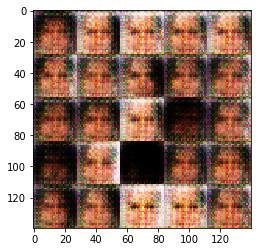

Epoch: 1/1  Batches:  610  Images seen: 19,520 Discriminator Loss: 0.2850  Generator Loss: 1.9465
Epoch: 1/1  Batches:  620  Images seen: 19,840 Discriminator Loss: 0.7170  Generator Loss: 1.1829
Epoch: 1/1  Batches:  630  Images seen: 20,160 Discriminator Loss: 0.3641  Generator Loss: 2.3965
Epoch: 1/1  Batches:  640  Images seen: 20,480 Discriminator Loss: 0.2676  Generator Loss: 2.5191
Epoch: 1/1  Batches:  650  Images seen: 20,800 Discriminator Loss: 0.2058  Generator Loss: 3.0254
Epoch: 1/1  Batches:  660  Images seen: 21,120 Discriminator Loss: 0.4971  Generator Loss: 1.7626
Epoch: 1/1  Batches:  670  Images seen: 21,440 Discriminator Loss: 0.5588  Generator Loss: 1.5510
Epoch: 1/1  Batches:  680  Images seen: 21,760 Discriminator Loss: 0.8460  Generator Loss: 3.5624
Epoch: 1/1  Batches:  690  Images seen: 22,080 Discriminator Loss: 1.0038  Generator Loss: 0.7912
Epoch: 1/1  Batches:  700  Images seen: 22,400 Discriminator Loss: 1.4430  Generator Loss: 0.6340


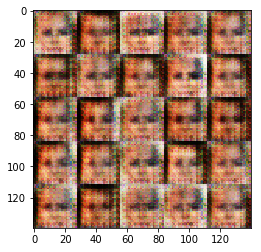

Epoch: 1/1  Batches:  710  Images seen: 22,720 Discriminator Loss: 0.5309  Generator Loss: 1.5799
Epoch: 1/1  Batches:  720  Images seen: 23,040 Discriminator Loss: 0.4006  Generator Loss: 2.0901
Epoch: 1/1  Batches:  730  Images seen: 23,360 Discriminator Loss: 0.6821  Generator Loss: 3.5366
Epoch: 1/1  Batches:  740  Images seen: 23,680 Discriminator Loss: 0.7729  Generator Loss: 1.1416
Epoch: 1/1  Batches:  750  Images seen: 24,000 Discriminator Loss: 0.4963  Generator Loss: 1.7062
Epoch: 1/1  Batches:  760  Images seen: 24,320 Discriminator Loss: 0.8303  Generator Loss: 1.1098
Epoch: 1/1  Batches:  770  Images seen: 24,640 Discriminator Loss: 0.5020  Generator Loss: 2.2285
Epoch: 1/1  Batches:  780  Images seen: 24,960 Discriminator Loss: 0.3790  Generator Loss: 1.9918
Epoch: 1/1  Batches:  790  Images seen: 25,280 Discriminator Loss: 1.1012  Generator Loss: 0.7369
Epoch: 1/1  Batches:  800  Images seen: 25,600 Discriminator Loss: 0.3959  Generator Loss: 2.2382


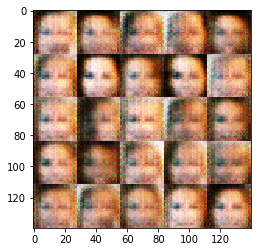

Epoch: 1/1  Batches:  810  Images seen: 25,920 Discriminator Loss: 0.5843  Generator Loss: 1.6757
Epoch: 1/1  Batches:  820  Images seen: 26,240 Discriminator Loss: 1.0786  Generator Loss: 0.5580
Epoch: 1/1  Batches:  830  Images seen: 26,560 Discriminator Loss: 0.7738  Generator Loss: 1.3858
Epoch: 1/1  Batches:  840  Images seen: 26,880 Discriminator Loss: 0.4950  Generator Loss: 1.4198
Epoch: 1/1  Batches:  850  Images seen: 27,200 Discriminator Loss: 0.4823  Generator Loss: 1.6362
Epoch: 1/1  Batches:  860  Images seen: 27,520 Discriminator Loss: 1.0194  Generator Loss: 0.7691
Epoch: 1/1  Batches:  870  Images seen: 27,840 Discriminator Loss: 0.7028  Generator Loss: 1.4181
Epoch: 1/1  Batches:  880  Images seen: 28,160 Discriminator Loss: 0.6368  Generator Loss: 1.7971
Epoch: 1/1  Batches:  890  Images seen: 28,480 Discriminator Loss: 0.8413  Generator Loss: 1.1415
Epoch: 1/1  Batches:  900  Images seen: 28,800 Discriminator Loss: 0.5961  Generator Loss: 1.4439


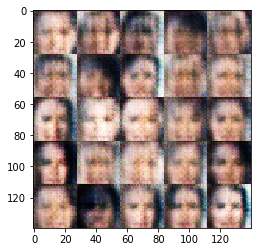

Epoch: 1/1  Batches:  910  Images seen: 29,120 Discriminator Loss: 0.6565  Generator Loss: 1.3361
Epoch: 1/1  Batches:  920  Images seen: 29,440 Discriminator Loss: 0.7550  Generator Loss: 0.9617
Epoch: 1/1  Batches:  930  Images seen: 29,760 Discriminator Loss: 0.9406  Generator Loss: 0.8277
Epoch: 1/1  Batches:  940  Images seen: 30,080 Discriminator Loss: 0.8121  Generator Loss: 1.3076
Epoch: 1/1  Batches:  950  Images seen: 30,400 Discriminator Loss: 0.6469  Generator Loss: 1.5046
Epoch: 1/1  Batches:  960  Images seen: 30,720 Discriminator Loss: 0.9194  Generator Loss: 1.0797
Epoch: 1/1  Batches:  970  Images seen: 31,040 Discriminator Loss: 0.9750  Generator Loss: 0.8496
Epoch: 1/1  Batches:  980  Images seen: 31,360 Discriminator Loss: 0.4788  Generator Loss: 1.6102
Epoch: 1/1  Batches:  990  Images seen: 31,680 Discriminator Loss: 0.8826  Generator Loss: 0.9605
Epoch: 1/1  Batches: 1,000  Images seen: 32,000 Discriminator Loss: 0.7009  Generator Loss: 1.3888


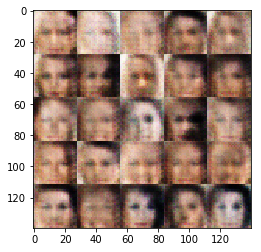

Epoch: 1/1  Batches: 1,010  Images seen: 32,320 Discriminator Loss: 0.5746  Generator Loss: 2.0844
Epoch: 1/1  Batches: 1,020  Images seen: 32,640 Discriminator Loss: 0.6928  Generator Loss: 1.1770
Epoch: 1/1  Batches: 1,030  Images seen: 32,960 Discriminator Loss: 0.8757  Generator Loss: 1.7911
Epoch: 1/1  Batches: 1,040  Images seen: 33,280 Discriminator Loss: 0.9731  Generator Loss: 0.9032
Epoch: 1/1  Batches: 1,050  Images seen: 33,600 Discriminator Loss: 1.1624  Generator Loss: 0.6009
Epoch: 1/1  Batches: 1,060  Images seen: 33,920 Discriminator Loss: 0.7646  Generator Loss: 0.9102
Epoch: 1/1  Batches: 1,070  Images seen: 34,240 Discriminator Loss: 0.4117  Generator Loss: 1.6608
Epoch: 1/1  Batches: 1,080  Images seen: 34,560 Discriminator Loss: 0.6375  Generator Loss: 1.3337
Epoch: 1/1  Batches: 1,090  Images seen: 34,880 Discriminator Loss: 0.6571  Generator Loss: 1.1934
Epoch: 1/1  Batches: 1,100  Images seen: 35,200 Discriminator Loss: 0.5199  Generator Loss: 2.2602


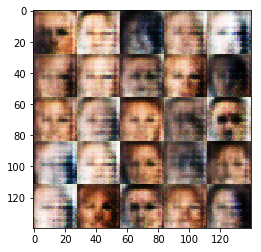

Epoch: 1/1  Batches: 1,110  Images seen: 35,520 Discriminator Loss: 0.8555  Generator Loss: 0.8800
Epoch: 1/1  Batches: 1,120  Images seen: 35,840 Discriminator Loss: 0.9379  Generator Loss: 1.0249
Epoch: 1/1  Batches: 1,130  Images seen: 36,160 Discriminator Loss: 0.9946  Generator Loss: 1.5934
Epoch: 1/1  Batches: 1,140  Images seen: 36,480 Discriminator Loss: 0.4713  Generator Loss: 1.7688
Epoch: 1/1  Batches: 1,150  Images seen: 36,800 Discriminator Loss: 0.8083  Generator Loss: 1.6183
Epoch: 1/1  Batches: 1,160  Images seen: 37,120 Discriminator Loss: 0.9730  Generator Loss: 0.8738
Epoch: 1/1  Batches: 1,170  Images seen: 37,440 Discriminator Loss: 0.6389  Generator Loss: 1.3832
Epoch: 1/1  Batches: 1,180  Images seen: 37,760 Discriminator Loss: 0.6365  Generator Loss: 1.2336
Epoch: 1/1  Batches: 1,190  Images seen: 38,080 Discriminator Loss: 0.7605  Generator Loss: 1.0390
Epoch: 1/1  Batches: 1,200  Images seen: 38,400 Discriminator Loss: 0.4896  Generator Loss: 2.0090


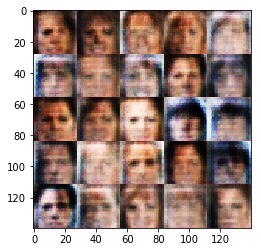

Epoch: 1/1  Batches: 1,210  Images seen: 38,720 Discriminator Loss: 0.6565  Generator Loss: 1.6575
Epoch: 1/1  Batches: 1,220  Images seen: 39,040 Discriminator Loss: 0.8966  Generator Loss: 1.1244
Epoch: 1/1  Batches: 1,230  Images seen: 39,360 Discriminator Loss: 0.8707  Generator Loss: 1.0523
Epoch: 1/1  Batches: 1,240  Images seen: 39,680 Discriminator Loss: 0.9168  Generator Loss: 0.8734
Epoch: 1/1  Batches: 1,250  Images seen: 40,000 Discriminator Loss: 0.7807  Generator Loss: 1.0881
Epoch: 1/1  Batches: 1,260  Images seen: 40,320 Discriminator Loss: 1.0978  Generator Loss: 0.8909
Epoch: 1/1  Batches: 1,270  Images seen: 40,640 Discriminator Loss: 0.9044  Generator Loss: 1.1175
Epoch: 1/1  Batches: 1,280  Images seen: 40,960 Discriminator Loss: 0.7142  Generator Loss: 1.7512
Epoch: 1/1  Batches: 1,290  Images seen: 41,280 Discriminator Loss: 0.9336  Generator Loss: 1.0004
Epoch: 1/1  Batches: 1,300  Images seen: 41,600 Discriminator Loss: 0.7829  Generator Loss: 1.6178


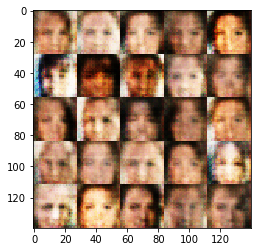

Epoch: 1/1  Batches: 1,310  Images seen: 41,920 Discriminator Loss: 0.8949  Generator Loss: 1.2480
Epoch: 1/1  Batches: 1,320  Images seen: 42,240 Discriminator Loss: 0.4677  Generator Loss: 1.7870
Epoch: 1/1  Batches: 1,330  Images seen: 42,560 Discriminator Loss: 0.8864  Generator Loss: 1.4608
Epoch: 1/1  Batches: 1,340  Images seen: 42,880 Discriminator Loss: 0.8106  Generator Loss: 1.0782
Epoch: 1/1  Batches: 1,350  Images seen: 43,200 Discriminator Loss: 0.9246  Generator Loss: 0.8321
Epoch: 1/1  Batches: 1,360  Images seen: 43,520 Discriminator Loss: 0.8060  Generator Loss: 1.4212
Epoch: 1/1  Batches: 1,370  Images seen: 43,840 Discriminator Loss: 0.7968  Generator Loss: 1.0458
Epoch: 1/1  Batches: 1,380  Images seen: 44,160 Discriminator Loss: 1.0386  Generator Loss: 0.8648
Epoch: 1/1  Batches: 1,390  Images seen: 44,480 Discriminator Loss: 1.0587  Generator Loss: 0.9738
Epoch: 1/1  Batches: 1,400  Images seen: 44,800 Discriminator Loss: 1.0474  Generator Loss: 0.9566


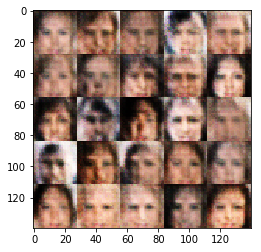

Epoch: 1/1  Batches: 1,410  Images seen: 45,120 Discriminator Loss: 0.9906  Generator Loss: 1.0356
Epoch: 1/1  Batches: 1,420  Images seen: 45,440 Discriminator Loss: 0.9686  Generator Loss: 0.8810
Epoch: 1/1  Batches: 1,430  Images seen: 45,760 Discriminator Loss: 0.9334  Generator Loss: 1.1596
Epoch: 1/1  Batches: 1,440  Images seen: 46,080 Discriminator Loss: 0.9589  Generator Loss: 0.7374
Epoch: 1/1  Batches: 1,450  Images seen: 46,400 Discriminator Loss: 0.8076  Generator Loss: 1.2476
Epoch: 1/1  Batches: 1,460  Images seen: 46,720 Discriminator Loss: 1.0445  Generator Loss: 0.7404
Epoch: 1/1  Batches: 1,470  Images seen: 47,040 Discriminator Loss: 0.8060  Generator Loss: 1.4857
Epoch: 1/1  Batches: 1,480  Images seen: 47,360 Discriminator Loss: 1.1934  Generator Loss: 0.5760
Epoch: 1/1  Batches: 1,490  Images seen: 47,680 Discriminator Loss: 0.8432  Generator Loss: 1.0860
Epoch: 1/1  Batches: 1,500  Images seen: 48,000 Discriminator Loss: 0.9196  Generator Loss: 0.9103


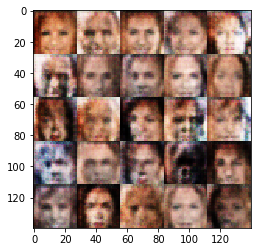

Epoch: 1/1  Batches: 1,510  Images seen: 48,320 Discriminator Loss: 1.1808  Generator Loss: 0.7127
Epoch: 1/1  Batches: 1,520  Images seen: 48,640 Discriminator Loss: 0.9111  Generator Loss: 1.1078
Epoch: 1/1  Batches: 1,530  Images seen: 48,960 Discriminator Loss: 0.8364  Generator Loss: 1.0226
Epoch: 1/1  Batches: 1,540  Images seen: 49,280 Discriminator Loss: 0.9062  Generator Loss: 0.8905
Epoch: 1/1  Batches: 1,550  Images seen: 49,600 Discriminator Loss: 0.7146  Generator Loss: 1.1806
Epoch: 1/1  Batches: 1,560  Images seen: 49,920 Discriminator Loss: 0.9487  Generator Loss: 1.0455
Epoch: 1/1  Batches: 1,570  Images seen: 50,240 Discriminator Loss: 1.1155  Generator Loss: 0.7550
Epoch: 1/1  Batches: 1,580  Images seen: 50,560 Discriminator Loss: 1.1869  Generator Loss: 1.3504
Epoch: 1/1  Batches: 1,590  Images seen: 50,880 Discriminator Loss: 0.9855  Generator Loss: 1.0209
Epoch: 1/1  Batches: 1,600  Images seen: 51,200 Discriminator Loss: 1.2534  Generator Loss: 0.6286


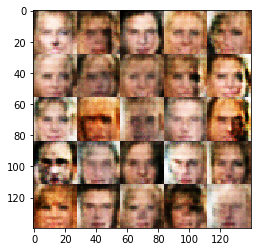

Epoch: 1/1  Batches: 1,610  Images seen: 51,520 Discriminator Loss: 1.3109  Generator Loss: 0.5250
Epoch: 1/1  Batches: 1,620  Images seen: 51,840 Discriminator Loss: 0.7806  Generator Loss: 1.3842
Epoch: 1/1  Batches: 1,630  Images seen: 52,160 Discriminator Loss: 0.7188  Generator Loss: 1.0303
Epoch: 1/1  Batches: 1,640  Images seen: 52,480 Discriminator Loss: 0.9217  Generator Loss: 0.9939
Epoch: 1/1  Batches: 1,650  Images seen: 52,800 Discriminator Loss: 0.7360  Generator Loss: 1.4616
Epoch: 1/1  Batches: 1,660  Images seen: 53,120 Discriminator Loss: 0.8299  Generator Loss: 1.0018
Epoch: 1/1  Batches: 1,670  Images seen: 53,440 Discriminator Loss: 0.9496  Generator Loss: 0.9700
Epoch: 1/1  Batches: 1,680  Images seen: 53,760 Discriminator Loss: 0.9657  Generator Loss: 0.9071
Epoch: 1/1  Batches: 1,690  Images seen: 54,080 Discriminator Loss: 0.8997  Generator Loss: 1.0599
Epoch: 1/1  Batches: 1,700  Images seen: 54,400 Discriminator Loss: 0.8335  Generator Loss: 1.4148


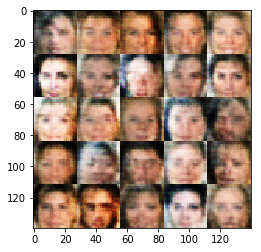

Epoch: 1/1  Batches: 1,710  Images seen: 54,720 Discriminator Loss: 0.9798  Generator Loss: 1.0365
Epoch: 1/1  Batches: 1,720  Images seen: 55,040 Discriminator Loss: 1.2048  Generator Loss: 1.8235
Epoch: 1/1  Batches: 1,730  Images seen: 55,360 Discriminator Loss: 1.0594  Generator Loss: 1.0515
Epoch: 1/1  Batches: 1,740  Images seen: 55,680 Discriminator Loss: 1.0005  Generator Loss: 0.8176
Epoch: 1/1  Batches: 1,750  Images seen: 56,000 Discriminator Loss: 0.9165  Generator Loss: 1.1400
Epoch: 1/1  Batches: 1,760  Images seen: 56,320 Discriminator Loss: 0.9059  Generator Loss: 1.2144
Epoch: 1/1  Batches: 1,770  Images seen: 56,640 Discriminator Loss: 0.9817  Generator Loss: 1.0356
Epoch: 1/1  Batches: 1,780  Images seen: 56,960 Discriminator Loss: 0.8664  Generator Loss: 1.1652
Epoch: 1/1  Batches: 1,790  Images seen: 57,280 Discriminator Loss: 0.9729  Generator Loss: 0.9465
Epoch: 1/1  Batches: 1,800  Images seen: 57,600 Discriminator Loss: 1.0215  Generator Loss: 0.9847


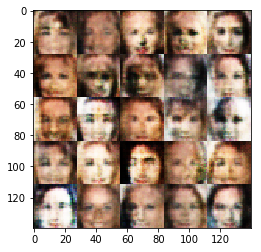

Epoch: 1/1  Batches: 1,810  Images seen: 57,920 Discriminator Loss: 1.2484  Generator Loss: 1.3734
Epoch: 1/1  Batches: 1,820  Images seen: 58,240 Discriminator Loss: 0.9389  Generator Loss: 0.7677
Epoch: 1/1  Batches: 1,830  Images seen: 58,560 Discriminator Loss: 1.0894  Generator Loss: 0.8297
Epoch: 1/1  Batches: 1,840  Images seen: 58,880 Discriminator Loss: 0.8146  Generator Loss: 1.5930
Epoch: 1/1  Batches: 1,850  Images seen: 59,200 Discriminator Loss: 0.8878  Generator Loss: 0.9308
Epoch: 1/1  Batches: 1,860  Images seen: 59,520 Discriminator Loss: 0.8689  Generator Loss: 1.0359
Epoch: 1/1  Batches: 1,870  Images seen: 59,840 Discriminator Loss: 0.9616  Generator Loss: 1.6951
Epoch: 1/1  Batches: 1,880  Images seen: 60,160 Discriminator Loss: 1.0381  Generator Loss: 1.0712
Epoch: 1/1  Batches: 1,890  Images seen: 60,480 Discriminator Loss: 0.9054  Generator Loss: 1.2654
Epoch: 1/1  Batches: 1,900  Images seen: 60,800 Discriminator Loss: 0.9305  Generator Loss: 1.1171


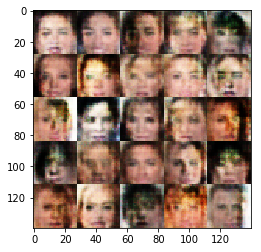

Epoch: 1/1  Batches: 1,910  Images seen: 61,120 Discriminator Loss: 0.8110  Generator Loss: 1.5103
Epoch: 1/1  Batches: 1,920  Images seen: 61,440 Discriminator Loss: 1.0165  Generator Loss: 0.8839
Epoch: 1/1  Batches: 1,930  Images seen: 61,760 Discriminator Loss: 1.0447  Generator Loss: 0.7917
Epoch: 1/1  Batches: 1,940  Images seen: 62,080 Discriminator Loss: 1.1555  Generator Loss: 0.7460
Epoch: 1/1  Batches: 1,950  Images seen: 62,400 Discriminator Loss: 0.7581  Generator Loss: 1.3696
Epoch: 1/1  Batches: 1,960  Images seen: 62,720 Discriminator Loss: 0.9973  Generator Loss: 0.9387
Epoch: 1/1  Batches: 1,970  Images seen: 63,040 Discriminator Loss: 0.7564  Generator Loss: 1.3024
Epoch: 1/1  Batches: 1,980  Images seen: 63,360 Discriminator Loss: 1.1125  Generator Loss: 0.7278
Epoch: 1/1  Batches: 1,990  Images seen: 63,680 Discriminator Loss: 1.1596  Generator Loss: 0.5659
Epoch: 1/1  Batches: 2,000  Images seen: 64,000 Discriminator Loss: 0.6842  Generator Loss: 1.6437


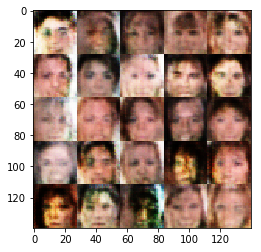

Epoch: 1/1  Batches: 2,010  Images seen: 64,320 Discriminator Loss: 0.9028  Generator Loss: 1.0688
Epoch: 1/1  Batches: 2,020  Images seen: 64,640 Discriminator Loss: 1.1315  Generator Loss: 0.9075
Epoch: 1/1  Batches: 2,030  Images seen: 64,960 Discriminator Loss: 0.9029  Generator Loss: 1.1333
Epoch: 1/1  Batches: 2,040  Images seen: 65,280 Discriminator Loss: 1.0092  Generator Loss: 0.9386
Epoch: 1/1  Batches: 2,050  Images seen: 65,600 Discriminator Loss: 0.9514  Generator Loss: 1.7335
Epoch: 1/1  Batches: 2,060  Images seen: 65,920 Discriminator Loss: 1.0100  Generator Loss: 0.7960
Epoch: 1/1  Batches: 2,070  Images seen: 66,240 Discriminator Loss: 0.8801  Generator Loss: 1.2881
Epoch: 1/1  Batches: 2,080  Images seen: 66,560 Discriminator Loss: 0.9895  Generator Loss: 1.0107
Epoch: 1/1  Batches: 2,090  Images seen: 66,880 Discriminator Loss: 1.2013  Generator Loss: 0.5992
Epoch: 1/1  Batches: 2,100  Images seen: 67,200 Discriminator Loss: 0.6836  Generator Loss: 1.1891


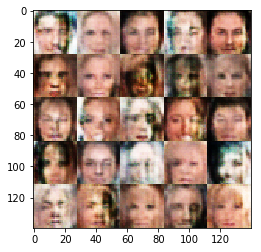

Epoch: 1/1  Batches: 2,110  Images seen: 67,520 Discriminator Loss: 0.9857  Generator Loss: 0.8871
Epoch: 1/1  Batches: 2,120  Images seen: 67,840 Discriminator Loss: 0.8575  Generator Loss: 1.0434
Epoch: 1/1  Batches: 2,130  Images seen: 68,160 Discriminator Loss: 0.9889  Generator Loss: 0.9018
Epoch: 1/1  Batches: 2,140  Images seen: 68,480 Discriminator Loss: 1.1483  Generator Loss: 0.8107
Epoch: 1/1  Batches: 2,150  Images seen: 68,800 Discriminator Loss: 0.7768  Generator Loss: 1.3587
Epoch: 1/1  Batches: 2,160  Images seen: 69,120 Discriminator Loss: 0.9529  Generator Loss: 1.0389
Epoch: 1/1  Batches: 2,170  Images seen: 69,440 Discriminator Loss: 0.9303  Generator Loss: 0.8875
Epoch: 1/1  Batches: 2,180  Images seen: 69,760 Discriminator Loss: 1.3780  Generator Loss: 0.4286
Epoch: 1/1  Batches: 2,190  Images seen: 70,080 Discriminator Loss: 1.4615  Generator Loss: 0.4604
Epoch: 1/1  Batches: 2,200  Images seen: 70,400 Discriminator Loss: 1.0906  Generator Loss: 1.4574


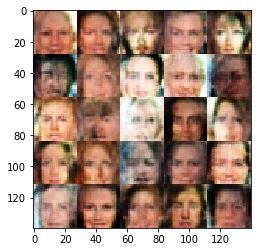

Epoch: 1/1  Batches: 2,210  Images seen: 70,720 Discriminator Loss: 0.7407  Generator Loss: 1.3631
Epoch: 1/1  Batches: 2,220  Images seen: 71,040 Discriminator Loss: 0.8986  Generator Loss: 1.1079
Epoch: 1/1  Batches: 2,230  Images seen: 71,360 Discriminator Loss: 1.0449  Generator Loss: 1.0229
Epoch: 1/1  Batches: 2,240  Images seen: 71,680 Discriminator Loss: 0.8022  Generator Loss: 1.3560
Epoch: 1/1  Batches: 2,250  Images seen: 72,000 Discriminator Loss: 0.7813  Generator Loss: 1.1496
Epoch: 1/1  Batches: 2,260  Images seen: 72,320 Discriminator Loss: 0.8483  Generator Loss: 1.7345
Epoch: 1/1  Batches: 2,270  Images seen: 72,640 Discriminator Loss: 1.1801  Generator Loss: 0.8372
Epoch: 1/1  Batches: 2,280  Images seen: 72,960 Discriminator Loss: 1.1562  Generator Loss: 0.6301
Epoch: 1/1  Batches: 2,290  Images seen: 73,280 Discriminator Loss: 0.8941  Generator Loss: 0.9137
Epoch: 1/1  Batches: 2,300  Images seen: 73,600 Discriminator Loss: 0.8427  Generator Loss: 1.2040


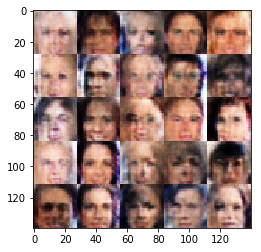

Epoch: 1/1  Batches: 2,310  Images seen: 73,920 Discriminator Loss: 0.8167  Generator Loss: 1.2108
Epoch: 1/1  Batches: 2,320  Images seen: 74,240 Discriminator Loss: 0.8090  Generator Loss: 1.0192
Epoch: 1/1  Batches: 2,330  Images seen: 74,560 Discriminator Loss: 0.9439  Generator Loss: 0.8709
Epoch: 1/1  Batches: 2,340  Images seen: 74,880 Discriminator Loss: 0.7872  Generator Loss: 1.1218
Epoch: 1/1  Batches: 2,350  Images seen: 75,200 Discriminator Loss: 0.8503  Generator Loss: 1.2744
Epoch: 1/1  Batches: 2,360  Images seen: 75,520 Discriminator Loss: 0.9402  Generator Loss: 1.1479
Epoch: 1/1  Batches: 2,370  Images seen: 75,840 Discriminator Loss: 1.2762  Generator Loss: 0.4946
Epoch: 1/1  Batches: 2,380  Images seen: 76,160 Discriminator Loss: 0.9927  Generator Loss: 1.0174
Epoch: 1/1  Batches: 2,390  Images seen: 76,480 Discriminator Loss: 0.9385  Generator Loss: 0.8420
Epoch: 1/1  Batches: 2,400  Images seen: 76,800 Discriminator Loss: 1.0113  Generator Loss: 0.8242


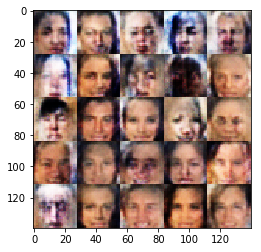

Epoch: 1/1  Batches: 2,410  Images seen: 77,120 Discriminator Loss: 0.8020  Generator Loss: 1.2021
Epoch: 1/1  Batches: 2,420  Images seen: 77,440 Discriminator Loss: 1.0110  Generator Loss: 0.8095
Epoch: 1/1  Batches: 2,430  Images seen: 77,760 Discriminator Loss: 0.9177  Generator Loss: 0.9125
Epoch: 1/1  Batches: 2,440  Images seen: 78,080 Discriminator Loss: 1.0133  Generator Loss: 1.0011
Epoch: 1/1  Batches: 2,450  Images seen: 78,400 Discriminator Loss: 0.9990  Generator Loss: 1.2684
Epoch: 1/1  Batches: 2,460  Images seen: 78,720 Discriminator Loss: 1.0257  Generator Loss: 0.6953
Epoch: 1/1  Batches: 2,470  Images seen: 79,040 Discriminator Loss: 1.0362  Generator Loss: 0.6606
Epoch: 1/1  Batches: 2,480  Images seen: 79,360 Discriminator Loss: 0.7371  Generator Loss: 1.3431
Epoch: 1/1  Batches: 2,490  Images seen: 79,680 Discriminator Loss: 0.9353  Generator Loss: 0.8747
Epoch: 1/1  Batches: 2,500  Images seen: 80,000 Discriminator Loss: 0.7776  Generator Loss: 1.3357


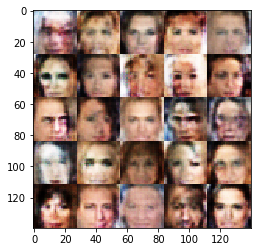

Epoch: 1/1  Batches: 2,510  Images seen: 80,320 Discriminator Loss: 1.0430  Generator Loss: 1.0811
Epoch: 1/1  Batches: 2,520  Images seen: 80,640 Discriminator Loss: 1.1201  Generator Loss: 0.6340
Epoch: 1/1  Batches: 2,530  Images seen: 80,960 Discriminator Loss: 1.0037  Generator Loss: 1.0388
Epoch: 1/1  Batches: 2,540  Images seen: 81,280 Discriminator Loss: 0.8071  Generator Loss: 1.0387
Epoch: 1/1  Batches: 2,550  Images seen: 81,600 Discriminator Loss: 0.9810  Generator Loss: 0.9707
Epoch: 1/1  Batches: 2,560  Images seen: 81,920 Discriminator Loss: 0.9895  Generator Loss: 0.7770
Epoch: 1/1  Batches: 2,570  Images seen: 82,240 Discriminator Loss: 1.0991  Generator Loss: 1.0524
Epoch: 1/1  Batches: 2,580  Images seen: 82,560 Discriminator Loss: 1.3078  Generator Loss: 0.4626
Epoch: 1/1  Batches: 2,590  Images seen: 82,880 Discriminator Loss: 1.1013  Generator Loss: 0.9633
Epoch: 1/1  Batches: 2,600  Images seen: 83,200 Discriminator Loss: 1.0850  Generator Loss: 0.6602


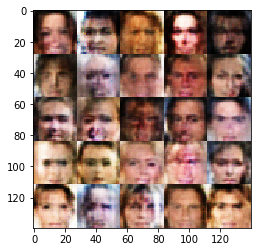

Epoch: 1/1  Batches: 2,610  Images seen: 83,520 Discriminator Loss: 0.9329  Generator Loss: 0.7750
Epoch: 1/1  Batches: 2,620  Images seen: 83,840 Discriminator Loss: 0.7818  Generator Loss: 1.0347
Epoch: 1/1  Batches: 2,630  Images seen: 84,160 Discriminator Loss: 1.0074  Generator Loss: 0.7311
Epoch: 1/1  Batches: 2,640  Images seen: 84,480 Discriminator Loss: 1.1139  Generator Loss: 0.5982
Epoch: 1/1  Batches: 2,650  Images seen: 84,800 Discriminator Loss: 0.7962  Generator Loss: 1.1480
Epoch: 1/1  Batches: 2,660  Images seen: 85,120 Discriminator Loss: 1.0464  Generator Loss: 1.0061
Epoch: 1/1  Batches: 2,670  Images seen: 85,440 Discriminator Loss: 1.1479  Generator Loss: 0.6809
Epoch: 1/1  Batches: 2,680  Images seen: 85,760 Discriminator Loss: 0.9911  Generator Loss: 0.7233
Epoch: 1/1  Batches: 2,690  Images seen: 86,080 Discriminator Loss: 1.1195  Generator Loss: 0.8614
Epoch: 1/1  Batches: 2,700  Images seen: 86,400 Discriminator Loss: 1.0457  Generator Loss: 1.1176


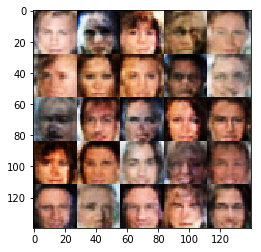

Epoch: 1/1  Batches: 2,710  Images seen: 86,720 Discriminator Loss: 0.8688  Generator Loss: 0.8440
Epoch: 1/1  Batches: 2,720  Images seen: 87,040 Discriminator Loss: 0.8340  Generator Loss: 0.9244
Epoch: 1/1  Batches: 2,730  Images seen: 87,360 Discriminator Loss: 1.0091  Generator Loss: 0.9416
Epoch: 1/1  Batches: 2,740  Images seen: 87,680 Discriminator Loss: 1.0054  Generator Loss: 0.7551
Epoch: 1/1  Batches: 2,750  Images seen: 88,000 Discriminator Loss: 0.9742  Generator Loss: 0.8810
Epoch: 1/1  Batches: 2,760  Images seen: 88,320 Discriminator Loss: 0.8480  Generator Loss: 1.0228
Epoch: 1/1  Batches: 2,770  Images seen: 88,640 Discriminator Loss: 0.6661  Generator Loss: 1.3704
Epoch: 1/1  Batches: 2,780  Images seen: 88,960 Discriminator Loss: 0.7952  Generator Loss: 1.1209
Epoch: 1/1  Batches: 2,790  Images seen: 89,280 Discriminator Loss: 1.0686  Generator Loss: 0.7001
Epoch: 1/1  Batches: 2,800  Images seen: 89,600 Discriminator Loss: 1.0275  Generator Loss: 0.9444


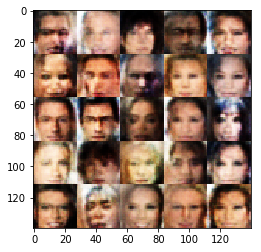

Epoch: 1/1  Batches: 2,810  Images seen: 89,920 Discriminator Loss: 1.0839  Generator Loss: 0.6189
Epoch: 1/1  Batches: 2,820  Images seen: 90,240 Discriminator Loss: 0.9861  Generator Loss: 0.7499
Epoch: 1/1  Batches: 2,830  Images seen: 90,560 Discriminator Loss: 0.7529  Generator Loss: 1.0904
Epoch: 1/1  Batches: 2,840  Images seen: 90,880 Discriminator Loss: 0.9023  Generator Loss: 0.8643
Epoch: 1/1  Batches: 2,850  Images seen: 91,200 Discriminator Loss: 0.9103  Generator Loss: 0.9892
Epoch: 1/1  Batches: 2,860  Images seen: 91,520 Discriminator Loss: 0.7772  Generator Loss: 1.1236
Epoch: 1/1  Batches: 2,870  Images seen: 91,840 Discriminator Loss: 0.8062  Generator Loss: 1.0379
Epoch: 1/1  Batches: 2,880  Images seen: 92,160 Discriminator Loss: 0.8743  Generator Loss: 1.0105
Epoch: 1/1  Batches: 2,890  Images seen: 92,480 Discriminator Loss: 1.0618  Generator Loss: 0.7521
Epoch: 1/1  Batches: 2,900  Images seen: 92,800 Discriminator Loss: 0.9770  Generator Loss: 1.0023


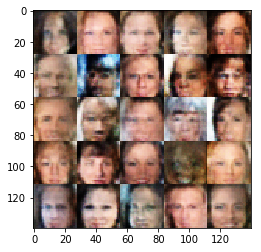

Epoch: 1/1  Batches: 2,910  Images seen: 93,120 Discriminator Loss: 0.9116  Generator Loss: 0.7916
Epoch: 1/1  Batches: 2,920  Images seen: 93,440 Discriminator Loss: 1.3263  Generator Loss: 0.5209
Epoch: 1/1  Batches: 2,930  Images seen: 93,760 Discriminator Loss: 1.0369  Generator Loss: 0.7793
Epoch: 1/1  Batches: 2,940  Images seen: 94,080 Discriminator Loss: 0.9269  Generator Loss: 1.1591
Epoch: 1/1  Batches: 2,950  Images seen: 94,400 Discriminator Loss: 1.0906  Generator Loss: 0.7589
Epoch: 1/1  Batches: 2,960  Images seen: 94,720 Discriminator Loss: 0.8303  Generator Loss: 1.0527
Epoch: 1/1  Batches: 2,970  Images seen: 95,040 Discriminator Loss: 1.1271  Generator Loss: 0.6193
Epoch: 1/1  Batches: 2,980  Images seen: 95,360 Discriminator Loss: 1.0406  Generator Loss: 0.7974
Epoch: 1/1  Batches: 2,990  Images seen: 95,680 Discriminator Loss: 1.0166  Generator Loss: 0.8056
Epoch: 1/1  Batches: 3,000  Images seen: 96,000 Discriminator Loss: 1.0027  Generator Loss: 0.8404


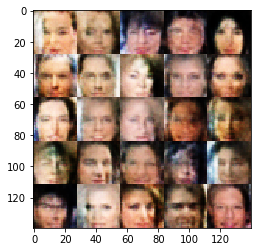

Epoch: 1/1  Batches: 3,010  Images seen: 96,320 Discriminator Loss: 0.7885  Generator Loss: 0.9921
Epoch: 1/1  Batches: 3,020  Images seen: 96,640 Discriminator Loss: 0.7895  Generator Loss: 1.1860
Epoch: 1/1  Batches: 3,030  Images seen: 96,960 Discriminator Loss: 0.8621  Generator Loss: 1.0086
Epoch: 1/1  Batches: 3,040  Images seen: 97,280 Discriminator Loss: 1.0338  Generator Loss: 0.8938
Epoch: 1/1  Batches: 3,050  Images seen: 97,600 Discriminator Loss: 0.9355  Generator Loss: 0.9073
Epoch: 1/1  Batches: 3,060  Images seen: 97,920 Discriminator Loss: 0.8292  Generator Loss: 1.2831
Epoch: 1/1  Batches: 3,070  Images seen: 98,240 Discriminator Loss: 0.9854  Generator Loss: 0.8460
Epoch: 1/1  Batches: 3,080  Images seen: 98,560 Discriminator Loss: 0.9653  Generator Loss: 0.8860
Epoch: 1/1  Batches: 3,090  Images seen: 98,880 Discriminator Loss: 1.0022  Generator Loss: 1.1403
Epoch: 1/1  Batches: 3,100  Images seen: 99,200 Discriminator Loss: 1.3900  Generator Loss: 0.6281


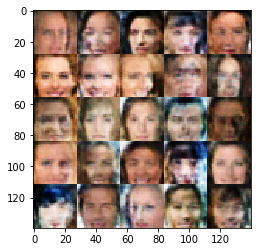

Epoch: 1/1  Batches: 3,110  Images seen: 99,520 Discriminator Loss: 0.9811  Generator Loss: 0.7454
Epoch: 1/1  Batches: 3,120  Images seen: 99,840 Discriminator Loss: 1.3650  Generator Loss: 0.8141
Epoch: 1/1  Batches: 3,130  Images seen: 100,160 Discriminator Loss: 0.9115  Generator Loss: 0.8748
Epoch: 1/1  Batches: 3,140  Images seen: 100,480 Discriminator Loss: 1.0532  Generator Loss: 0.9746
Epoch: 1/1  Batches: 3,150  Images seen: 100,800 Discriminator Loss: 1.0052  Generator Loss: 0.7596
Epoch: 1/1  Batches: 3,160  Images seen: 101,120 Discriminator Loss: 0.9190  Generator Loss: 0.8130
Epoch: 1/1  Batches: 3,170  Images seen: 101,440 Discriminator Loss: 0.9091  Generator Loss: 1.2559
Epoch: 1/1  Batches: 3,180  Images seen: 101,760 Discriminator Loss: 0.9009  Generator Loss: 1.2630
Epoch: 1/1  Batches: 3,190  Images seen: 102,080 Discriminator Loss: 1.0324  Generator Loss: 1.2427
Epoch: 1/1  Batches: 3,200  Images seen: 102,400 Discriminator Loss: 1.0063  Generator Loss: 0.8626


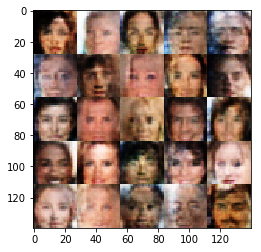

Epoch: 1/1  Batches: 3,210  Images seen: 102,720 Discriminator Loss: 1.0372  Generator Loss: 0.8613
Epoch: 1/1  Batches: 3,220  Images seen: 103,040 Discriminator Loss: 0.9300  Generator Loss: 0.8472
Epoch: 1/1  Batches: 3,230  Images seen: 103,360 Discriminator Loss: 1.0329  Generator Loss: 0.7927
Epoch: 1/1  Batches: 3,240  Images seen: 103,680 Discriminator Loss: 0.6021  Generator Loss: 1.7346
Epoch: 1/1  Batches: 3,250  Images seen: 104,000 Discriminator Loss: 1.0596  Generator Loss: 0.8206
Epoch: 1/1  Batches: 3,260  Images seen: 104,320 Discriminator Loss: 0.8712  Generator Loss: 0.9026
Epoch: 1/1  Batches: 3,270  Images seen: 104,640 Discriminator Loss: 1.3111  Generator Loss: 0.6442
Epoch: 1/1  Batches: 3,280  Images seen: 104,960 Discriminator Loss: 1.0576  Generator Loss: 0.8866
Epoch: 1/1  Batches: 3,290  Images seen: 105,280 Discriminator Loss: 0.8641  Generator Loss: 1.1278
Epoch: 1/1  Batches: 3,300  Images seen: 105,600 Discriminator Loss: 0.9331  Generator Loss: 1.0177


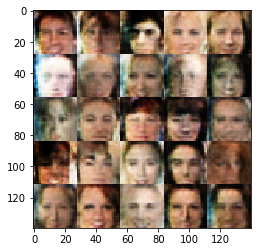

Epoch: 1/1  Batches: 3,310  Images seen: 105,920 Discriminator Loss: 1.1608  Generator Loss: 0.5697
Epoch: 1/1  Batches: 3,320  Images seen: 106,240 Discriminator Loss: 0.9081  Generator Loss: 0.8192
Epoch: 1/1  Batches: 3,330  Images seen: 106,560 Discriminator Loss: 0.7603  Generator Loss: 1.1670
Epoch: 1/1  Batches: 3,340  Images seen: 106,880 Discriminator Loss: 1.1405  Generator Loss: 0.5481
Epoch: 1/1  Batches: 3,350  Images seen: 107,200 Discriminator Loss: 0.8604  Generator Loss: 0.9839
Epoch: 1/1  Batches: 3,360  Images seen: 107,520 Discriminator Loss: 1.0206  Generator Loss: 0.8762
Epoch: 1/1  Batches: 3,370  Images seen: 107,840 Discriminator Loss: 1.2027  Generator Loss: 0.7097
Epoch: 1/1  Batches: 3,380  Images seen: 108,160 Discriminator Loss: 1.1732  Generator Loss: 0.5688
Epoch: 1/1  Batches: 3,390  Images seen: 108,480 Discriminator Loss: 1.0673  Generator Loss: 0.7651
Epoch: 1/1  Batches: 3,400  Images seen: 108,800 Discriminator Loss: 0.9290  Generator Loss: 1.4081


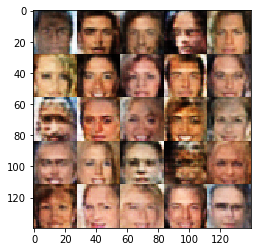

Epoch: 1/1  Batches: 3,410  Images seen: 109,120 Discriminator Loss: 0.9010  Generator Loss: 0.9828
Epoch: 1/1  Batches: 3,420  Images seen: 109,440 Discriminator Loss: 0.8663  Generator Loss: 1.3306
Epoch: 1/1  Batches: 3,430  Images seen: 109,760 Discriminator Loss: 1.1129  Generator Loss: 0.8404
Epoch: 1/1  Batches: 3,440  Images seen: 110,080 Discriminator Loss: 1.1597  Generator Loss: 0.6574
Epoch: 1/1  Batches: 3,450  Images seen: 110,400 Discriminator Loss: 1.0013  Generator Loss: 0.9322
Epoch: 1/1  Batches: 3,460  Images seen: 110,720 Discriminator Loss: 0.9730  Generator Loss: 0.8311
Epoch: 1/1  Batches: 3,470  Images seen: 111,040 Discriminator Loss: 1.0865  Generator Loss: 1.5318
Epoch: 1/1  Batches: 3,480  Images seen: 111,360 Discriminator Loss: 0.6807  Generator Loss: 1.1692
Epoch: 1/1  Batches: 3,490  Images seen: 111,680 Discriminator Loss: 0.8625  Generator Loss: 1.0063
Epoch: 1/1  Batches: 3,500  Images seen: 112,000 Discriminator Loss: 1.0599  Generator Loss: 0.8430


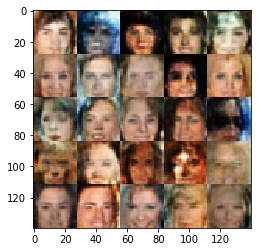

Epoch: 1/1  Batches: 3,510  Images seen: 112,320 Discriminator Loss: 1.0975  Generator Loss: 0.6064
Epoch: 1/1  Batches: 3,520  Images seen: 112,640 Discriminator Loss: 0.8828  Generator Loss: 0.9391
Epoch: 1/1  Batches: 3,530  Images seen: 112,960 Discriminator Loss: 1.0761  Generator Loss: 0.8729
Epoch: 1/1  Batches: 3,540  Images seen: 113,280 Discriminator Loss: 0.8030  Generator Loss: 1.0212
Epoch: 1/1  Batches: 3,550  Images seen: 113,600 Discriminator Loss: 1.0657  Generator Loss: 0.8382
Epoch: 1/1  Batches: 3,560  Images seen: 113,920 Discriminator Loss: 0.8760  Generator Loss: 1.2451
Epoch: 1/1  Batches: 3,570  Images seen: 114,240 Discriminator Loss: 0.8326  Generator Loss: 1.1777
Epoch: 1/1  Batches: 3,580  Images seen: 114,560 Discriminator Loss: 1.1489  Generator Loss: 0.7591
Epoch: 1/1  Batches: 3,590  Images seen: 114,880 Discriminator Loss: 0.9301  Generator Loss: 0.9329
Epoch: 1/1  Batches: 3,600  Images seen: 115,200 Discriminator Loss: 1.0461  Generator Loss: 0.6625


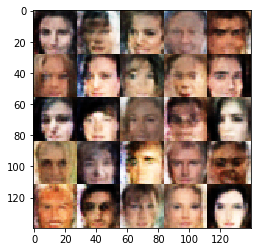

Epoch: 1/1  Batches: 3,610  Images seen: 115,520 Discriminator Loss: 0.9167  Generator Loss: 0.7936
Epoch: 1/1  Batches: 3,620  Images seen: 115,840 Discriminator Loss: 0.7735  Generator Loss: 1.1336
Epoch: 1/1  Batches: 3,630  Images seen: 116,160 Discriminator Loss: 0.9712  Generator Loss: 1.3522
Epoch: 1/1  Batches: 3,640  Images seen: 116,480 Discriminator Loss: 1.0293  Generator Loss: 0.9665
Epoch: 1/1  Batches: 3,650  Images seen: 116,800 Discriminator Loss: 1.0532  Generator Loss: 0.8771
Epoch: 1/1  Batches: 3,660  Images seen: 117,120 Discriminator Loss: 1.0214  Generator Loss: 1.1515
Epoch: 1/1  Batches: 3,670  Images seen: 117,440 Discriminator Loss: 0.9563  Generator Loss: 0.8237
Epoch: 1/1  Batches: 3,680  Images seen: 117,760 Discriminator Loss: 0.8978  Generator Loss: 0.9316
Epoch: 1/1  Batches: 3,690  Images seen: 118,080 Discriminator Loss: 0.8772  Generator Loss: 1.0300
Epoch: 1/1  Batches: 3,700  Images seen: 118,400 Discriminator Loss: 0.9314  Generator Loss: 0.8102


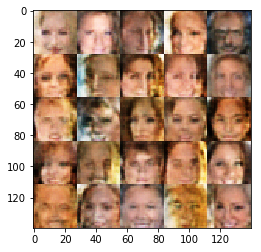

Epoch: 1/1  Batches: 3,710  Images seen: 118,720 Discriminator Loss: 0.9566  Generator Loss: 0.9114
Epoch: 1/1  Batches: 3,720  Images seen: 119,040 Discriminator Loss: 0.6458  Generator Loss: 1.1098
Epoch: 1/1  Batches: 3,730  Images seen: 119,360 Discriminator Loss: 0.8784  Generator Loss: 0.9500
Epoch: 1/1  Batches: 3,740  Images seen: 119,680 Discriminator Loss: 1.0247  Generator Loss: 0.7552
Epoch: 1/1  Batches: 3,750  Images seen: 120,000 Discriminator Loss: 0.9260  Generator Loss: 1.2592
Epoch: 1/1  Batches: 3,760  Images seen: 120,320 Discriminator Loss: 1.0458  Generator Loss: 0.6509
Epoch: 1/1  Batches: 3,770  Images seen: 120,640 Discriminator Loss: 1.2081  Generator Loss: 0.7725
Epoch: 1/1  Batches: 3,780  Images seen: 120,960 Discriminator Loss: 0.8896  Generator Loss: 0.8281
Epoch: 1/1  Batches: 3,790  Images seen: 121,280 Discriminator Loss: 0.9991  Generator Loss: 0.8959
Epoch: 1/1  Batches: 3,800  Images seen: 121,600 Discriminator Loss: 1.0194  Generator Loss: 0.8893


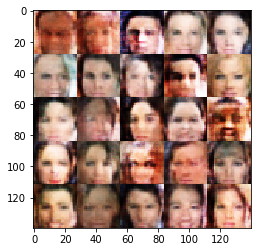

Epoch: 1/1  Batches: 3,810  Images seen: 121,920 Discriminator Loss: 1.2417  Generator Loss: 0.7917
Epoch: 1/1  Batches: 3,820  Images seen: 122,240 Discriminator Loss: 1.0305  Generator Loss: 0.6955
Epoch: 1/1  Batches: 3,830  Images seen: 122,560 Discriminator Loss: 0.9709  Generator Loss: 0.9633
Epoch: 1/1  Batches: 3,840  Images seen: 122,880 Discriminator Loss: 1.2594  Generator Loss: 0.4466
Epoch: 1/1  Batches: 3,850  Images seen: 123,200 Discriminator Loss: 0.9603  Generator Loss: 0.9404
Epoch: 1/1  Batches: 3,860  Images seen: 123,520 Discriminator Loss: 1.0878  Generator Loss: 0.9571
Epoch: 1/1  Batches: 3,870  Images seen: 123,840 Discriminator Loss: 1.1014  Generator Loss: 1.6385
Epoch: 1/1  Batches: 3,880  Images seen: 124,160 Discriminator Loss: 0.9919  Generator Loss: 0.7701
Epoch: 1/1  Batches: 3,890  Images seen: 124,480 Discriminator Loss: 1.0565  Generator Loss: 0.6776
Epoch: 1/1  Batches: 3,900  Images seen: 124,800 Discriminator Loss: 1.1024  Generator Loss: 0.6657


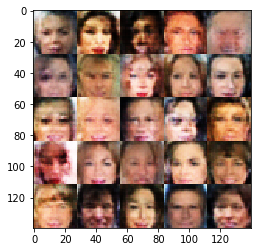

Epoch: 1/1  Batches: 3,910  Images seen: 125,120 Discriminator Loss: 0.9844  Generator Loss: 0.8969
Epoch: 1/1  Batches: 3,920  Images seen: 125,440 Discriminator Loss: 0.8737  Generator Loss: 0.9501
Epoch: 1/1  Batches: 3,930  Images seen: 125,760 Discriminator Loss: 1.3118  Generator Loss: 0.5423
Epoch: 1/1  Batches: 3,940  Images seen: 126,080 Discriminator Loss: 0.7538  Generator Loss: 1.0144
Epoch: 1/1  Batches: 3,950  Images seen: 126,400 Discriminator Loss: 1.2299  Generator Loss: 0.9229
Epoch: 1/1  Batches: 3,960  Images seen: 126,720 Discriminator Loss: 0.9959  Generator Loss: 0.7695
Epoch: 1/1  Batches: 3,970  Images seen: 127,040 Discriminator Loss: 1.0414  Generator Loss: 0.7023
Epoch: 1/1  Batches: 3,980  Images seen: 127,360 Discriminator Loss: 0.7701  Generator Loss: 1.0859
Epoch: 1/1  Batches: 3,990  Images seen: 127,680 Discriminator Loss: 0.8181  Generator Loss: 1.3589
Epoch: 1/1  Batches: 4,000  Images seen: 128,000 Discriminator Loss: 1.4112  Generator Loss: 0.5361


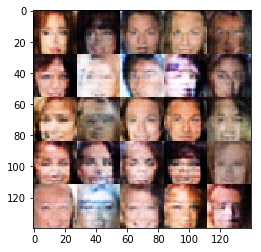

Epoch: 1/1  Batches: 4,010  Images seen: 128,320 Discriminator Loss: 0.9708  Generator Loss: 0.8870
Epoch: 1/1  Batches: 4,020  Images seen: 128,640 Discriminator Loss: 1.0673  Generator Loss: 0.7023
Epoch: 1/1  Batches: 4,030  Images seen: 128,960 Discriminator Loss: 0.9495  Generator Loss: 0.7656
Epoch: 1/1  Batches: 4,040  Images seen: 129,280 Discriminator Loss: 1.3111  Generator Loss: 0.4828
Epoch: 1/1  Batches: 4,050  Images seen: 129,600 Discriminator Loss: 0.7763  Generator Loss: 1.7127
Epoch: 1/1  Batches: 4,060  Images seen: 129,920 Discriminator Loss: 1.0309  Generator Loss: 1.1880
Epoch: 1/1  Batches: 4,070  Images seen: 130,240 Discriminator Loss: 0.8068  Generator Loss: 1.1456
Epoch: 1/1  Batches: 4,080  Images seen: 130,560 Discriminator Loss: 1.1399  Generator Loss: 0.6878
Epoch: 1/1  Batches: 4,090  Images seen: 130,880 Discriminator Loss: 0.9823  Generator Loss: 0.7864
Epoch: 1/1  Batches: 4,100  Images seen: 131,200 Discriminator Loss: 1.0901  Generator Loss: 0.9601


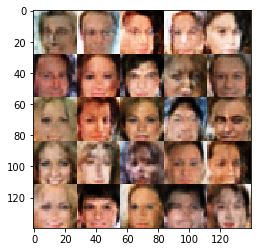

Epoch: 1/1  Batches: 4,110  Images seen: 131,520 Discriminator Loss: 0.9080  Generator Loss: 0.8218
Epoch: 1/1  Batches: 4,120  Images seen: 131,840 Discriminator Loss: 0.9234  Generator Loss: 0.9547
Epoch: 1/1  Batches: 4,130  Images seen: 132,160 Discriminator Loss: 1.0860  Generator Loss: 0.5541
Epoch: 1/1  Batches: 4,140  Images seen: 132,480 Discriminator Loss: 0.7361  Generator Loss: 1.2573
Epoch: 1/1  Batches: 4,150  Images seen: 132,800 Discriminator Loss: 1.0066  Generator Loss: 0.8056
Epoch: 1/1  Batches: 4,160  Images seen: 133,120 Discriminator Loss: 0.6106  Generator Loss: 1.2681
Epoch: 1/1  Batches: 4,170  Images seen: 133,440 Discriminator Loss: 1.0569  Generator Loss: 0.7511
Epoch: 1/1  Batches: 4,180  Images seen: 133,760 Discriminator Loss: 0.9653  Generator Loss: 0.8732
Epoch: 1/1  Batches: 4,190  Images seen: 134,080 Discriminator Loss: 0.8157  Generator Loss: 1.0989
Epoch: 1/1  Batches: 4,200  Images seen: 134,400 Discriminator Loss: 1.1456  Generator Loss: 0.7268


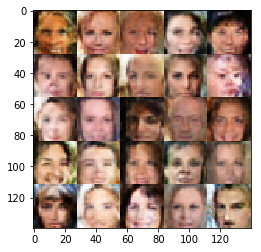

Epoch: 1/1  Batches: 4,210  Images seen: 134,720 Discriminator Loss: 0.9019  Generator Loss: 0.8483
Epoch: 1/1  Batches: 4,220  Images seen: 135,040 Discriminator Loss: 0.9741  Generator Loss: 0.6765
Epoch: 1/1  Batches: 4,230  Images seen: 135,360 Discriminator Loss: 0.8548  Generator Loss: 0.9310
Epoch: 1/1  Batches: 4,240  Images seen: 135,680 Discriminator Loss: 0.6907  Generator Loss: 1.3519
Epoch: 1/1  Batches: 4,250  Images seen: 136,000 Discriminator Loss: 0.7570  Generator Loss: 1.1680
Epoch: 1/1  Batches: 4,260  Images seen: 136,320 Discriminator Loss: 1.1907  Generator Loss: 0.9979
Epoch: 1/1  Batches: 4,270  Images seen: 136,640 Discriminator Loss: 1.0521  Generator Loss: 0.7968
Epoch: 1/1  Batches: 4,280  Images seen: 136,960 Discriminator Loss: 0.6640  Generator Loss: 1.2726
Epoch: 1/1  Batches: 4,290  Images seen: 137,280 Discriminator Loss: 0.9988  Generator Loss: 0.9145
Epoch: 1/1  Batches: 4,300  Images seen: 137,600 Discriminator Loss: 0.9581  Generator Loss: 0.9803


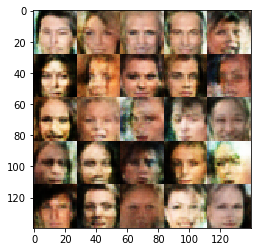

Epoch: 1/1  Batches: 4,310  Images seen: 137,920 Discriminator Loss: 0.9460  Generator Loss: 0.8931
Epoch: 1/1  Batches: 4,320  Images seen: 138,240 Discriminator Loss: 0.8571  Generator Loss: 0.9543
Epoch: 1/1  Batches: 4,330  Images seen: 138,560 Discriminator Loss: 1.1275  Generator Loss: 0.8494
Epoch: 1/1  Batches: 4,340  Images seen: 138,880 Discriminator Loss: 0.9790  Generator Loss: 0.6846
Epoch: 1/1  Batches: 4,350  Images seen: 139,200 Discriminator Loss: 0.8058  Generator Loss: 1.0792
Epoch: 1/1  Batches: 4,360  Images seen: 139,520 Discriminator Loss: 0.7811  Generator Loss: 1.1888
Epoch: 1/1  Batches: 4,370  Images seen: 139,840 Discriminator Loss: 0.9332  Generator Loss: 0.9207
Epoch: 1/1  Batches: 4,380  Images seen: 140,160 Discriminator Loss: 1.1216  Generator Loss: 0.7033
Epoch: 1/1  Batches: 4,390  Images seen: 140,480 Discriminator Loss: 0.9656  Generator Loss: 1.0192
Epoch: 1/1  Batches: 4,400  Images seen: 140,800 Discriminator Loss: 0.9863  Generator Loss: 0.7060


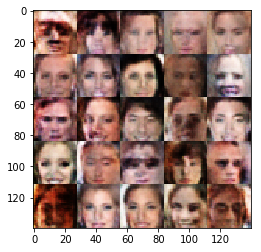

Epoch: 1/1  Batches: 4,410  Images seen: 141,120 Discriminator Loss: 0.8801  Generator Loss: 1.1461
Epoch: 1/1  Batches: 4,420  Images seen: 141,440 Discriminator Loss: 0.7687  Generator Loss: 0.9965
Epoch: 1/1  Batches: 4,430  Images seen: 141,760 Discriminator Loss: 0.9761  Generator Loss: 0.9491
Epoch: 1/1  Batches: 4,440  Images seen: 142,080 Discriminator Loss: 1.0705  Generator Loss: 1.0515
Epoch: 1/1  Batches: 4,450  Images seen: 142,400 Discriminator Loss: 0.8333  Generator Loss: 0.8593
Epoch: 1/1  Batches: 4,460  Images seen: 142,720 Discriminator Loss: 0.8713  Generator Loss: 0.8034
Epoch: 1/1  Batches: 4,470  Images seen: 143,040 Discriminator Loss: 0.8816  Generator Loss: 1.1117
Epoch: 1/1  Batches: 4,480  Images seen: 143,360 Discriminator Loss: 0.8607  Generator Loss: 0.9417
Epoch: 1/1  Batches: 4,490  Images seen: 143,680 Discriminator Loss: 0.7399  Generator Loss: 1.2679
Epoch: 1/1  Batches: 4,500  Images seen: 144,000 Discriminator Loss: 1.0431  Generator Loss: 0.6546


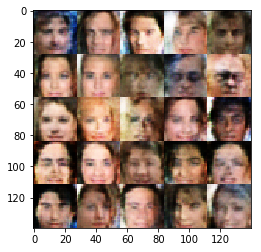

Epoch: 1/1  Batches: 4,510  Images seen: 144,320 Discriminator Loss: 0.7464  Generator Loss: 1.2054
Epoch: 1/1  Batches: 4,520  Images seen: 144,640 Discriminator Loss: 1.0152  Generator Loss: 0.8207
Epoch: 1/1  Batches: 4,530  Images seen: 144,960 Discriminator Loss: 1.0747  Generator Loss: 0.7566
Epoch: 1/1  Batches: 4,540  Images seen: 145,280 Discriminator Loss: 0.9711  Generator Loss: 0.8609
Epoch: 1/1  Batches: 4,550  Images seen: 145,600 Discriminator Loss: 0.8679  Generator Loss: 0.8383
Epoch: 1/1  Batches: 4,560  Images seen: 145,920 Discriminator Loss: 0.7942  Generator Loss: 1.2241
Epoch: 1/1  Batches: 4,570  Images seen: 146,240 Discriminator Loss: 0.7427  Generator Loss: 1.2592
Epoch: 1/1  Batches: 4,580  Images seen: 146,560 Discriminator Loss: 1.2290  Generator Loss: 0.6713
Epoch: 1/1  Batches: 4,590  Images seen: 146,880 Discriminator Loss: 1.1013  Generator Loss: 0.9291
Epoch: 1/1  Batches: 4,600  Images seen: 147,200 Discriminator Loss: 0.8568  Generator Loss: 0.9138


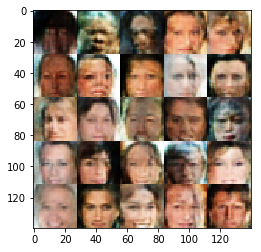

Epoch: 1/1  Batches: 4,610  Images seen: 147,520 Discriminator Loss: 1.0225  Generator Loss: 0.7018
Epoch: 1/1  Batches: 4,620  Images seen: 147,840 Discriminator Loss: 0.9663  Generator Loss: 0.8876
Epoch: 1/1  Batches: 4,630  Images seen: 148,160 Discriminator Loss: 0.9509  Generator Loss: 0.8245
Epoch: 1/1  Batches: 4,640  Images seen: 148,480 Discriminator Loss: 1.2097  Generator Loss: 0.5184
Epoch: 1/1  Batches: 4,650  Images seen: 148,800 Discriminator Loss: 1.0553  Generator Loss: 0.8857
Epoch: 1/1  Batches: 4,660  Images seen: 149,120 Discriminator Loss: 1.1812  Generator Loss: 0.5589
Epoch: 1/1  Batches: 4,670  Images seen: 149,440 Discriminator Loss: 1.0514  Generator Loss: 1.4631
Epoch: 1/1  Batches: 4,680  Images seen: 149,760 Discriminator Loss: 1.2174  Generator Loss: 0.7647
Epoch: 1/1  Batches: 4,690  Images seen: 150,080 Discriminator Loss: 0.8607  Generator Loss: 1.2001
Epoch: 1/1  Batches: 4,700  Images seen: 150,400 Discriminator Loss: 1.0836  Generator Loss: 1.0113


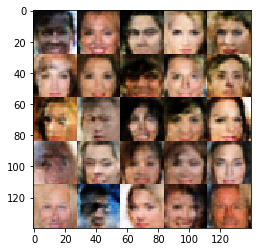

Epoch: 1/1  Batches: 4,710  Images seen: 150,720 Discriminator Loss: 1.3829  Generator Loss: 0.5292
Epoch: 1/1  Batches: 4,720  Images seen: 151,040 Discriminator Loss: 1.0410  Generator Loss: 0.8696
Epoch: 1/1  Batches: 4,730  Images seen: 151,360 Discriminator Loss: 1.2111  Generator Loss: 0.5201
Epoch: 1/1  Batches: 4,740  Images seen: 151,680 Discriminator Loss: 0.8079  Generator Loss: 1.2108
Epoch: 1/1  Batches: 4,750  Images seen: 152,000 Discriminator Loss: 0.7988  Generator Loss: 1.2188
Epoch: 1/1  Batches: 4,760  Images seen: 152,320 Discriminator Loss: 1.1007  Generator Loss: 0.6008
Epoch: 1/1  Batches: 4,770  Images seen: 152,640 Discriminator Loss: 1.0420  Generator Loss: 0.8909
Epoch: 1/1  Batches: 4,780  Images seen: 152,960 Discriminator Loss: 1.0507  Generator Loss: 0.8247
Epoch: 1/1  Batches: 4,790  Images seen: 153,280 Discriminator Loss: 1.2026  Generator Loss: 0.6738
Epoch: 1/1  Batches: 4,800  Images seen: 153,600 Discriminator Loss: 0.7135  Generator Loss: 1.3976


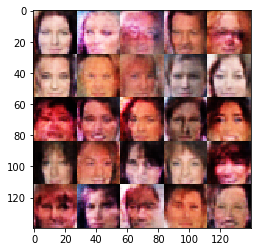

Epoch: 1/1  Batches: 4,810  Images seen: 153,920 Discriminator Loss: 0.9292  Generator Loss: 0.9348
Epoch: 1/1  Batches: 4,820  Images seen: 154,240 Discriminator Loss: 1.0452  Generator Loss: 0.9132
Epoch: 1/1  Batches: 4,830  Images seen: 154,560 Discriminator Loss: 0.9961  Generator Loss: 0.8186
Epoch: 1/1  Batches: 4,840  Images seen: 154,880 Discriminator Loss: 0.9119  Generator Loss: 0.8663
Epoch: 1/1  Batches: 4,850  Images seen: 155,200 Discriminator Loss: 0.9542  Generator Loss: 0.8333
Epoch: 1/1  Batches: 4,860  Images seen: 155,520 Discriminator Loss: 1.0380  Generator Loss: 0.7361
Epoch: 1/1  Batches: 4,870  Images seen: 155,840 Discriminator Loss: 1.1005  Generator Loss: 1.0178
Epoch: 1/1  Batches: 4,880  Images seen: 156,160 Discriminator Loss: 0.6677  Generator Loss: 1.2489
Epoch: 1/1  Batches: 4,890  Images seen: 156,480 Discriminator Loss: 1.2499  Generator Loss: 0.6034
Epoch: 1/1  Batches: 4,900  Images seen: 156,800 Discriminator Loss: 1.4401  Generator Loss: 0.3864


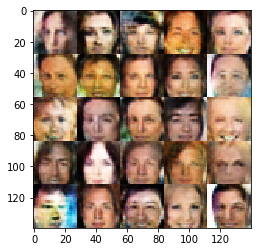

Epoch: 1/1  Batches: 4,910  Images seen: 157,120 Discriminator Loss: 0.8039  Generator Loss: 0.9757
Epoch: 1/1  Batches: 4,920  Images seen: 157,440 Discriminator Loss: 1.2010  Generator Loss: 0.5962
Epoch: 1/1  Batches: 4,930  Images seen: 157,760 Discriminator Loss: 1.2200  Generator Loss: 0.6830
Epoch: 1/1  Batches: 4,940  Images seen: 158,080 Discriminator Loss: 0.9060  Generator Loss: 0.9184
Epoch: 1/1  Batches: 4,950  Images seen: 158,400 Discriminator Loss: 1.3303  Generator Loss: 0.4992
Epoch: 1/1  Batches: 4,960  Images seen: 158,720 Discriminator Loss: 0.8875  Generator Loss: 1.1764
Epoch: 1/1  Batches: 4,970  Images seen: 159,040 Discriminator Loss: 1.2999  Generator Loss: 0.5624
Epoch: 1/1  Batches: 4,980  Images seen: 159,360 Discriminator Loss: 0.7531  Generator Loss: 1.2263
Epoch: 1/1  Batches: 4,990  Images seen: 159,680 Discriminator Loss: 0.9702  Generator Loss: 0.8223
Epoch: 1/1  Batches: 5,000  Images seen: 160,000 Discriminator Loss: 1.2256  Generator Loss: 0.9453


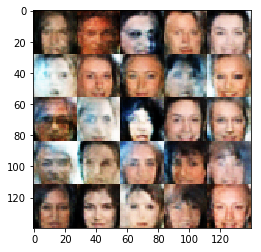

Epoch: 1/1  Batches: 5,010  Images seen: 160,320 Discriminator Loss: 1.1155  Generator Loss: 0.7272
Epoch: 1/1  Batches: 5,020  Images seen: 160,640 Discriminator Loss: 1.0579  Generator Loss: 0.7286
Epoch: 1/1  Batches: 5,030  Images seen: 160,960 Discriminator Loss: 0.8064  Generator Loss: 1.0998
Epoch: 1/1  Batches: 5,040  Images seen: 161,280 Discriminator Loss: 1.2180  Generator Loss: 0.5964
Epoch: 1/1  Batches: 5,050  Images seen: 161,600 Discriminator Loss: 1.1007  Generator Loss: 0.8133
Epoch: 1/1  Batches: 5,060  Images seen: 161,920 Discriminator Loss: 1.0619  Generator Loss: 0.6879
Epoch: 1/1  Batches: 5,070  Images seen: 162,240 Discriminator Loss: 0.9181  Generator Loss: 1.0500
Epoch: 1/1  Batches: 5,080  Images seen: 162,560 Discriminator Loss: 1.2524  Generator Loss: 0.6016
Epoch: 1/1  Batches: 5,090  Images seen: 162,880 Discriminator Loss: 1.0510  Generator Loss: 0.7163
Epoch: 1/1  Batches: 5,100  Images seen: 163,200 Discriminator Loss: 1.2272  Generator Loss: 0.6152


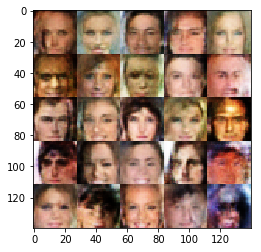

Epoch: 1/1  Batches: 5,110  Images seen: 163,520 Discriminator Loss: 1.0908  Generator Loss: 0.6693
Epoch: 1/1  Batches: 5,120  Images seen: 163,840 Discriminator Loss: 1.1598  Generator Loss: 0.6644
Epoch: 1/1  Batches: 5,130  Images seen: 164,160 Discriminator Loss: 1.1001  Generator Loss: 0.5842
Epoch: 1/1  Batches: 5,140  Images seen: 164,480 Discriminator Loss: 1.1627  Generator Loss: 0.8021
Epoch: 1/1  Batches: 5,150  Images seen: 164,800 Discriminator Loss: 1.0696  Generator Loss: 0.9163
Epoch: 1/1  Batches: 5,160  Images seen: 165,120 Discriminator Loss: 1.2233  Generator Loss: 0.5202
Epoch: 1/1  Batches: 5,170  Images seen: 165,440 Discriminator Loss: 1.0938  Generator Loss: 0.8256
Epoch: 1/1  Batches: 5,180  Images seen: 165,760 Discriminator Loss: 0.9183  Generator Loss: 1.0158
Epoch: 1/1  Batches: 5,190  Images seen: 166,080 Discriminator Loss: 1.1000  Generator Loss: 0.8079
Epoch: 1/1  Batches: 5,200  Images seen: 166,400 Discriminator Loss: 0.7919  Generator Loss: 1.1721


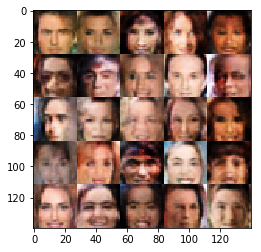

Epoch: 1/1  Batches: 5,210  Images seen: 166,720 Discriminator Loss: 1.3295  Generator Loss: 0.4945
Epoch: 1/1  Batches: 5,220  Images seen: 167,040 Discriminator Loss: 0.9811  Generator Loss: 1.4219
Epoch: 1/1  Batches: 5,230  Images seen: 167,360 Discriminator Loss: 0.9259  Generator Loss: 0.8072
Epoch: 1/1  Batches: 5,240  Images seen: 167,680 Discriminator Loss: 0.7028  Generator Loss: 1.2355
Epoch: 1/1  Batches: 5,250  Images seen: 168,000 Discriminator Loss: 0.9681  Generator Loss: 1.0998
Epoch: 1/1  Batches: 5,260  Images seen: 168,320 Discriminator Loss: 0.9208  Generator Loss: 0.9017
Epoch: 1/1  Batches: 5,270  Images seen: 168,640 Discriminator Loss: 1.0057  Generator Loss: 1.1465
Epoch: 1/1  Batches: 5,280  Images seen: 168,960 Discriminator Loss: 1.3031  Generator Loss: 0.7769
Epoch: 1/1  Batches: 5,290  Images seen: 169,280 Discriminator Loss: 1.1589  Generator Loss: 0.5752
Epoch: 1/1  Batches: 5,300  Images seen: 169,600 Discriminator Loss: 1.1415  Generator Loss: 0.8861


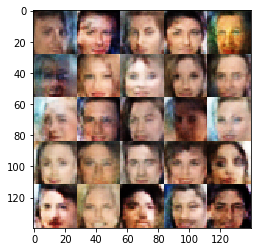

Epoch: 1/1  Batches: 5,310  Images seen: 169,920 Discriminator Loss: 1.1290  Generator Loss: 0.7832
Epoch: 1/1  Batches: 5,320  Images seen: 170,240 Discriminator Loss: 1.0727  Generator Loss: 0.9001
Epoch: 1/1  Batches: 5,330  Images seen: 170,560 Discriminator Loss: 1.0049  Generator Loss: 0.8588
Epoch: 1/1  Batches: 5,340  Images seen: 170,880 Discriminator Loss: 0.9041  Generator Loss: 0.8094
Epoch: 1/1  Batches: 5,350  Images seen: 171,200 Discriminator Loss: 1.0301  Generator Loss: 0.8999
Epoch: 1/1  Batches: 5,360  Images seen: 171,520 Discriminator Loss: 1.2345  Generator Loss: 0.6009
Epoch: 1/1  Batches: 5,370  Images seen: 171,840 Discriminator Loss: 0.9932  Generator Loss: 0.8478
Epoch: 1/1  Batches: 5,380  Images seen: 172,160 Discriminator Loss: 1.1384  Generator Loss: 0.7028
Epoch: 1/1  Batches: 5,390  Images seen: 172,480 Discriminator Loss: 1.2337  Generator Loss: 0.5209
Epoch: 1/1  Batches: 5,400  Images seen: 172,800 Discriminator Loss: 0.9525  Generator Loss: 1.0406


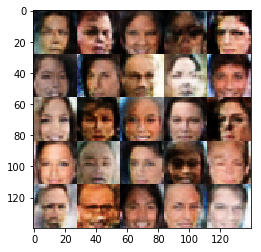

Epoch: 1/1  Batches: 5,410  Images seen: 173,120 Discriminator Loss: 1.3257  Generator Loss: 0.7365
Epoch: 1/1  Batches: 5,420  Images seen: 173,440 Discriminator Loss: 0.8892  Generator Loss: 0.9858
Epoch: 1/1  Batches: 5,430  Images seen: 173,760 Discriminator Loss: 0.7054  Generator Loss: 1.2587
Epoch: 1/1  Batches: 5,440  Images seen: 174,080 Discriminator Loss: 1.0737  Generator Loss: 0.7844
Epoch: 1/1  Batches: 5,450  Images seen: 174,400 Discriminator Loss: 0.9575  Generator Loss: 0.8140
Epoch: 1/1  Batches: 5,460  Images seen: 174,720 Discriminator Loss: 1.0498  Generator Loss: 0.7189
Epoch: 1/1  Batches: 5,470  Images seen: 175,040 Discriminator Loss: 0.9597  Generator Loss: 0.7106
Epoch: 1/1  Batches: 5,480  Images seen: 175,360 Discriminator Loss: 1.2404  Generator Loss: 0.5349
Epoch: 1/1  Batches: 5,490  Images seen: 175,680 Discriminator Loss: 0.7897  Generator Loss: 1.0714
Epoch: 1/1  Batches: 5,500  Images seen: 176,000 Discriminator Loss: 1.1176  Generator Loss: 0.6139


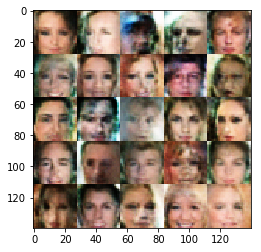

Epoch: 1/1  Batches: 5,510  Images seen: 176,320 Discriminator Loss: 0.8091  Generator Loss: 1.1900
Epoch: 1/1  Batches: 5,520  Images seen: 176,640 Discriminator Loss: 1.2859  Generator Loss: 0.5057
Epoch: 1/1  Batches: 5,530  Images seen: 176,960 Discriminator Loss: 0.9431  Generator Loss: 0.8111
Epoch: 1/1  Batches: 5,540  Images seen: 177,280 Discriminator Loss: 1.0351  Generator Loss: 0.8787
Epoch: 1/1  Batches: 5,550  Images seen: 177,600 Discriminator Loss: 0.9484  Generator Loss: 0.8404
Epoch: 1/1  Batches: 5,560  Images seen: 177,920 Discriminator Loss: 0.9660  Generator Loss: 0.8383
Epoch: 1/1  Batches: 5,570  Images seen: 178,240 Discriminator Loss: 1.1242  Generator Loss: 0.6635
Epoch: 1/1  Batches: 5,580  Images seen: 178,560 Discriminator Loss: 1.0755  Generator Loss: 0.6966
Epoch: 1/1  Batches: 5,590  Images seen: 178,880 Discriminator Loss: 0.8379  Generator Loss: 0.9433
Epoch: 1/1  Batches: 5,600  Images seen: 179,200 Discriminator Loss: 0.8430  Generator Loss: 0.9286


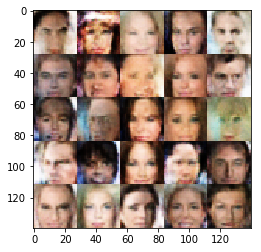

Epoch: 1/1  Batches: 5,610  Images seen: 179,520 Discriminator Loss: 1.0910  Generator Loss: 0.7204
Epoch: 1/1  Batches: 5,620  Images seen: 179,840 Discriminator Loss: 0.8617  Generator Loss: 1.0864
Epoch: 1/1  Batches: 5,630  Images seen: 180,160 Discriminator Loss: 1.3866  Generator Loss: 0.4888
Epoch: 1/1  Batches: 5,640  Images seen: 180,480 Discriminator Loss: 0.7419  Generator Loss: 1.0038
Epoch: 1/1  Batches: 5,650  Images seen: 180,800 Discriminator Loss: 1.1624  Generator Loss: 0.5774
Epoch: 1/1  Batches: 5,660  Images seen: 181,120 Discriminator Loss: 0.7827  Generator Loss: 1.3241
Epoch: 1/1  Batches: 5,670  Images seen: 181,440 Discriminator Loss: 0.7010  Generator Loss: 1.4333
Epoch: 1/1  Batches: 5,680  Images seen: 181,760 Discriminator Loss: 1.2300  Generator Loss: 0.4896
Epoch: 1/1  Batches: 5,690  Images seen: 182,080 Discriminator Loss: 1.0300  Generator Loss: 1.2894
Epoch: 1/1  Batches: 5,700  Images seen: 182,400 Discriminator Loss: 1.0440  Generator Loss: 0.8025


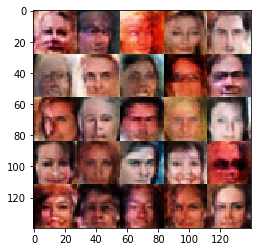

Epoch: 1/1  Batches: 5,710  Images seen: 182,720 Discriminator Loss: 0.6114  Generator Loss: 1.6750
Epoch: 1/1  Batches: 5,720  Images seen: 183,040 Discriminator Loss: 1.2787  Generator Loss: 0.6563
Epoch: 1/1  Batches: 5,730  Images seen: 183,360 Discriminator Loss: 1.2486  Generator Loss: 0.7207
Epoch: 1/1  Batches: 5,740  Images seen: 183,680 Discriminator Loss: 1.0205  Generator Loss: 0.7970
Epoch: 1/1  Batches: 5,750  Images seen: 184,000 Discriminator Loss: 1.0122  Generator Loss: 0.8673
Epoch: 1/1  Batches: 5,760  Images seen: 184,320 Discriminator Loss: 0.9551  Generator Loss: 0.8164
Epoch: 1/1  Batches: 5,770  Images seen: 184,640 Discriminator Loss: 0.9597  Generator Loss: 0.7507
Epoch: 1/1  Batches: 5,780  Images seen: 184,960 Discriminator Loss: 0.8484  Generator Loss: 1.0529
Epoch: 1/1  Batches: 5,790  Images seen: 185,280 Discriminator Loss: 0.8119  Generator Loss: 1.2440
Epoch: 1/1  Batches: 5,800  Images seen: 185,600 Discriminator Loss: 0.7843  Generator Loss: 1.0520


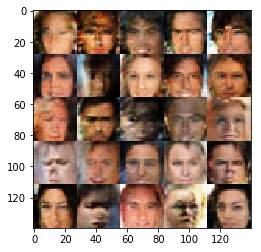

Epoch: 1/1  Batches: 5,810  Images seen: 185,920 Discriminator Loss: 1.0277  Generator Loss: 0.7319
Epoch: 1/1  Batches: 5,820  Images seen: 186,240 Discriminator Loss: 0.7672  Generator Loss: 1.3527
Epoch: 1/1  Batches: 5,830  Images seen: 186,560 Discriminator Loss: 1.2006  Generator Loss: 0.6756
Epoch: 1/1  Batches: 5,840  Images seen: 186,880 Discriminator Loss: 1.0454  Generator Loss: 0.8842
Epoch: 1/1  Batches: 5,850  Images seen: 187,200 Discriminator Loss: 0.8634  Generator Loss: 0.8593
Epoch: 1/1  Batches: 5,860  Images seen: 187,520 Discriminator Loss: 0.8392  Generator Loss: 0.8625
Epoch: 1/1  Batches: 5,870  Images seen: 187,840 Discriminator Loss: 1.0809  Generator Loss: 0.7265
Epoch: 1/1  Batches: 5,880  Images seen: 188,160 Discriminator Loss: 1.0640  Generator Loss: 1.1319
Epoch: 1/1  Batches: 5,890  Images seen: 188,480 Discriminator Loss: 1.0924  Generator Loss: 0.7230
Epoch: 1/1  Batches: 5,900  Images seen: 188,800 Discriminator Loss: 0.8867  Generator Loss: 0.9634


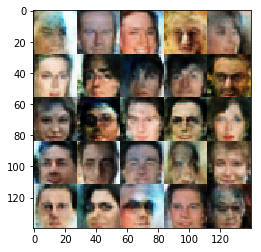

Epoch: 1/1  Batches: 5,910  Images seen: 189,120 Discriminator Loss: 1.0925  Generator Loss: 0.9289
Epoch: 1/1  Batches: 5,920  Images seen: 189,440 Discriminator Loss: 1.0447  Generator Loss: 0.8317
Epoch: 1/1  Batches: 5,930  Images seen: 189,760 Discriminator Loss: 1.1400  Generator Loss: 0.6815
Epoch: 1/1  Batches: 5,940  Images seen: 190,080 Discriminator Loss: 0.8255  Generator Loss: 0.9749
Epoch: 1/1  Batches: 5,950  Images seen: 190,400 Discriminator Loss: 0.9821  Generator Loss: 0.7393
Epoch: 1/1  Batches: 5,960  Images seen: 190,720 Discriminator Loss: 1.3655  Generator Loss: 0.5050
Epoch: 1/1  Batches: 5,970  Images seen: 191,040 Discriminator Loss: 1.2363  Generator Loss: 0.5130
Epoch: 1/1  Batches: 5,980  Images seen: 191,360 Discriminator Loss: 1.0102  Generator Loss: 0.8242
Epoch: 1/1  Batches: 5,990  Images seen: 191,680 Discriminator Loss: 0.5969  Generator Loss: 1.2860
Epoch: 1/1  Batches: 6,000  Images seen: 192,000 Discriminator Loss: 1.1954  Generator Loss: 0.6657


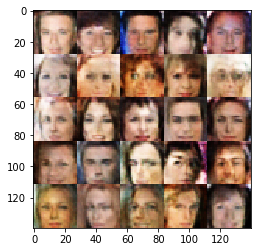

Epoch: 1/1  Batches: 6,010  Images seen: 192,320 Discriminator Loss: 0.9891  Generator Loss: 0.9326
Epoch: 1/1  Batches: 6,020  Images seen: 192,640 Discriminator Loss: 1.2891  Generator Loss: 0.5890
Epoch: 1/1  Batches: 6,030  Images seen: 192,960 Discriminator Loss: 0.9819  Generator Loss: 0.8996
Epoch: 1/1  Batches: 6,040  Images seen: 193,280 Discriminator Loss: 0.9064  Generator Loss: 0.8875
Epoch: 1/1  Batches: 6,050  Images seen: 193,600 Discriminator Loss: 0.8022  Generator Loss: 1.0981
Epoch: 1/1  Batches: 6,060  Images seen: 193,920 Discriminator Loss: 0.9120  Generator Loss: 0.7570
Epoch: 1/1  Batches: 6,070  Images seen: 194,240 Discriminator Loss: 1.0493  Generator Loss: 0.8949
Epoch: 1/1  Batches: 6,080  Images seen: 194,560 Discriminator Loss: 1.1726  Generator Loss: 0.6974
Epoch: 1/1  Batches: 6,090  Images seen: 194,880 Discriminator Loss: 1.1208  Generator Loss: 0.6225
Epoch: 1/1  Batches: 6,100  Images seen: 195,200 Discriminator Loss: 1.2612  Generator Loss: 0.8426


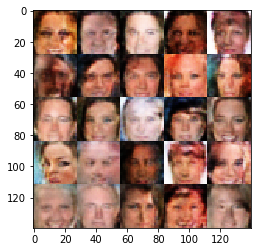

Epoch: 1/1  Batches: 6,110  Images seen: 195,520 Discriminator Loss: 1.1315  Generator Loss: 0.6487
Epoch: 1/1  Batches: 6,120  Images seen: 195,840 Discriminator Loss: 1.2448  Generator Loss: 0.6903
Epoch: 1/1  Batches: 6,130  Images seen: 196,160 Discriminator Loss: 1.0546  Generator Loss: 0.7485
Epoch: 1/1  Batches: 6,140  Images seen: 196,480 Discriminator Loss: 0.9282  Generator Loss: 0.8445
Epoch: 1/1  Batches: 6,150  Images seen: 196,800 Discriminator Loss: 0.8136  Generator Loss: 0.9345
Epoch: 1/1  Batches: 6,160  Images seen: 197,120 Discriminator Loss: 1.0602  Generator Loss: 0.6227
Epoch: 1/1  Batches: 6,170  Images seen: 197,440 Discriminator Loss: 0.8746  Generator Loss: 1.0442
Epoch: 1/1  Batches: 6,180  Images seen: 197,760 Discriminator Loss: 1.1296  Generator Loss: 0.5870
Epoch: 1/1  Batches: 6,190  Images seen: 198,080 Discriminator Loss: 1.2172  Generator Loss: 0.5388
Epoch: 1/1  Batches: 6,200  Images seen: 198,400 Discriminator Loss: 1.0319  Generator Loss: 0.7496


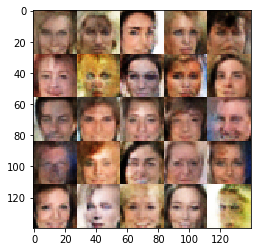

Epoch: 1/1  Batches: 6,210  Images seen: 198,720 Discriminator Loss: 0.9007  Generator Loss: 0.9669
Epoch: 1/1  Batches: 6,220  Images seen: 199,040 Discriminator Loss: 1.3160  Generator Loss: 0.5967
Epoch: 1/1  Batches: 6,230  Images seen: 199,360 Discriminator Loss: 0.8369  Generator Loss: 0.8302
Epoch: 1/1  Batches: 6,240  Images seen: 199,680 Discriminator Loss: 1.1754  Generator Loss: 0.6803
Epoch: 1/1  Batches: 6,250  Images seen: 200,000 Discriminator Loss: 0.9575  Generator Loss: 0.9456
Epoch: 1/1  Batches: 6,260  Images seen: 200,320 Discriminator Loss: 0.8835  Generator Loss: 0.9705
Epoch: 1/1  Batches: 6,270  Images seen: 200,640 Discriminator Loss: 0.9945  Generator Loss: 0.6960
Epoch: 1/1  Batches: 6,280  Images seen: 200,960 Discriminator Loss: 1.1172  Generator Loss: 0.6619
Epoch: 1/1  Batches: 6,290  Images seen: 201,280 Discriminator Loss: 0.9230  Generator Loss: 0.9105
Epoch: 1/1  Batches: 6,300  Images seen: 201,600 Discriminator Loss: 0.7134  Generator Loss: 1.0202


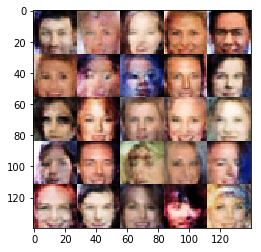

Epoch: 1/1  Batches: 6,310  Images seen: 201,920 Discriminator Loss: 0.8974  Generator Loss: 1.0470
Epoch: 1/1  Batches: 6,320  Images seen: 202,240 Discriminator Loss: 1.1823  Generator Loss: 0.5651
Epoch: 1/1  Batches: 6,330  Images seen: 202,560 Discriminator Loss: 0.9281  Generator Loss: 0.7673


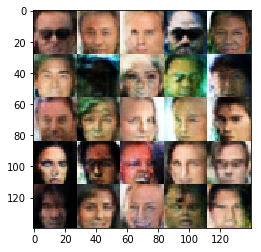

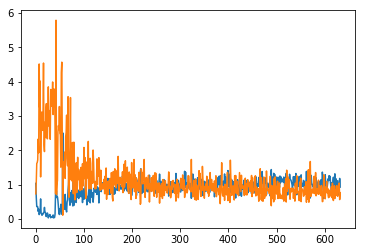

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.